# Optimization of electricity consumption at a metallurgical plant

**Description of the project**

In order to optimize production costs, the metallurgical plant LLC "Steel Bird" decided to reduce electricity consumption at the stage of steel processing. We need to build a model that will predict the temperature of the steel.

**Description of processing step**

Steel is processed in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is lined with refractory bricks from the inside. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket.
Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed by adding pieces of alloy from the bulk material hopper or wire through a special tribe apparatus.
Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then the alloy is stirred and measurements are taken again. This cycle is repeated until the desired chemical composition of the alloy and the optimum melting temperature are reached.
Next, the molten steel is sent for metal finishing or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks.

**Project objectives**

- Find the best prediction model for the last measured temperature.

As a criterion for assessing the quality of the model, it needs to use the MAE metric. The metric value must be less than 6.6. It is necessary to consider the following classes of models: decision tree, boosting, neural networks.
- Analyze the importance of the main factors.
- For one of the identified important factors, conduct additional research:

Show a plot of the factor versus the target variable.

**Decision progress**

\- Step 1. Loading data
\- Step 2. Exploratory data analysis
\- Step 3. Model Training
\- Step 4. Testing the model and demonstrating how it works
\- Step 5. General conclusion on the work


**Data Description**
  
The data is stored in tables in a PostgreSQL database:
- steel.data_arc - data about the electrodes,
- steel.data_bulk - data on the supply of bulk materials (volume),
- steel.data_bulk_time - data on the supply of bulk materials (time),
- steel.data_gas — data on alloy gas purge,
- steel.data_temp — temperature measurement results,
- steel.data_wire - data on wire materials (volume),
- steel.data_wire_time - data on wire materials (time).

Table `steel.data_arc`
- key - batch number,
- BeginHeat — heating start time,
- EndHeat — heating end time,
- ActivePower - active power value,
- ReactivePower — reactive power value.

Table `steel.data_bulk`
- key - batch number,
- Bulk1 … Bulk15 — the volume of the supplied material.

Table `steel.data_bulk_time`
- key - batch number,
- Bulk1 … Bulk15 — material supply time.

Table `steel.data_gas`
- key - batch number,
- gas — volume of supplied gas.

Table `steel.data_temp`
- key - batch number,
- MesaureTime - measurement time,
- Temperature — temperature value.

Table `steel.data_wire`
- key - batch number,
- Wire1 ... Wire15 - the volume of the supplied wire materials.

Table `steel.data_wire_time`
- key - batch number,
- Wire1 ... Wire15 - time for feeding wire materials.

In all files, the `key` column contains the batch number. Tables can have multiple rows with the same `key` value: they correspond to different processing iterations.

In [1]:
!pip install skorch

In [2]:
!pip install phik

# Loading data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import random
import skorch
import warnings
import phik

from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from skorch import NeuralNetRegressor
from torch import optim
from phik.report import plot_correlation_matrix
from phik import report

sns.set(color_codes=True)
warnings.filterwarnings('ignore')

In [4]:
db_config = {
'user': 'praktikum_student', # username,
'pwd': 'Sdf4$2;d-d30pp', # password,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # connection port,
'db': 'data-science-final' # database name,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

In [5]:
query = '''
SELECT *
FROM steel.data_arc;
'''

steel_data_arc = pd.read_sql_query(query, con=engine) 
steel_data_arc.head()   #  electrode data

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


In [6]:
query = '''
SELECT *
FROM steel.data_bulk;
'''

steel_data_bulk = pd.read_sql_query(query, con=engine) 
steel_data_bulk.head()   # bulk material feed data (volume)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
query = '''
SELECT *
FROM steel.data_bulk_time;
'''

steel_data_bulk_time = pd.read_sql_query(query, con=engine) 
steel_data_bulk_time.head()   # bulk material feed data (time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


In [8]:
query = '''
SELECT *
FROM steel.data_gas;
'''

steel_data_gas = pd.read_sql_query(query, con=engine) 
steel_data_gas.head()   # alloy gas purge data

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [9]:
query = '''
SELECT *
FROM steel.data_temp;
'''

steel_data_temp = pd.read_sql_query(query, con=engine) 
steel_data_temp.head()   # temperature measurement results

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


In [10]:
query = '''
SELECT *
FROM steel.data_wire;
'''

steel_data_wire = pd.read_sql_query(query, con=engine) 
steel_data_wire.head()   # wire materials data (volume)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
query = '''
SELECT *
FROM steel.data_wire_time;
'''

steel_data_wire_time = pd.read_sql_query(query, con=engine) 
steel_data_wire_time.head()   # wire material data (time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


All seven tables with data are loaded. There are no problems with uploading data. All tables have a common key. At first glance, you can see that there are missing values in the data.

# Exploratory data analysis

In [12]:
tab_list = [steel_data_arc, 
            steel_data_bulk, 
            steel_data_bulk_time, 
            steel_data_gas, 
            steel_data_temp, 
            steel_data_wire, 
            steel_data_wire_time]

In [13]:
for i in tab_list:
    display(i.info())
    display(i.describe(include='all'))
    display(i.duplicated().value_counts())
    print('______________________________________________')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,13663,13690,NaN,NaN
top,NaN,21:46:41,22:21:32,NaN,NaN
freq,NaN,4,4,NaN,NaN
mean,1615.220422,NaN,NaN,0.670441,0.452592
std,934.571502,NaN,NaN,0.408159,5.878702
min,1.000000,NaN,NaN,0.030002,-715.504924
25%,806.000000,NaN,NaN,0.395297,0.290991
50%,1617.000000,NaN,NaN,0.555517,0.415962
75%,2429.000000,NaN,NaN,0.857034,0.637371


False    14876
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


False    3129
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1288,1009,77,576,25,1,19,176,177,2407,18,2760,2213
top,NaN,17:50:19,08:36:19,17:28:50,05:46:37,08:36:19,18:52:57,11:37:42,17:46:11,00:04:56,01:36:24,16:45:05,05:49:32,00:39:35,05:49:32,05:49:32
freq,NaN,1,1,2,2,1,1,1,1,1,1,1,3,1,3,3
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


False    3129
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


False    3239
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,MesaureTime,Temperature
count,15907.000000,15907,13006.000000
unique,NaN,14558,NaN
top,NaN,08:22:39,NaN
freq,NaN,4,NaN
mean,1607.880870,NaN,1591.840920
std,942.212073,NaN,21.375851
min,1.000000,NaN,1191.000000
25%,790.000000,NaN,1581.000000
50%,1618.000000,NaN,1591.000000
75%,2427.000000,NaN,1601.000000


False    15907
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


False    3081
dtype: int64

______________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3000,1075,63,14,1,73,11,19,29
top,NaN,10:07:11,11:15:54,04:47:53,08:48:23,16:01:07,08:37:20,12:42:00,00:03:32,16:09:11
freq,NaN,2,2,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


False    3081
dtype: int64

______________________________________________


In [14]:
steel_data_arc.describe(include='all')

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,13663,13690,NaN,NaN
top,NaN,21:46:41,22:21:32,NaN,NaN
freq,NaN,4,4,NaN,NaN
mean,1615.220422,NaN,NaN,0.670441,0.452592
std,934.571502,NaN,NaN,0.408159,5.878702
min,1.000000,NaN,NaN,0.030002,-715.504924
25%,806.000000,NaN,NaN,0.395297,0.290991
50%,1617.000000,NaN,NaN,0.555517,0.415962
75%,2429.000000,NaN,NaN,0.857034,0.637371


In [15]:
def data_distribution(tab):
    for column in tab:
        if tab[column].dtype == 'int64' or tab[column].dtype == 'float64': 
            display(_=sns.catplot(y=column, kind='violin', data=tab))

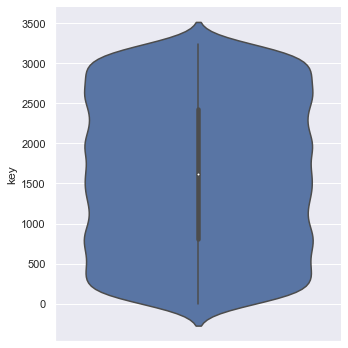

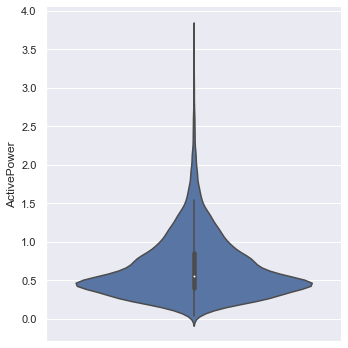

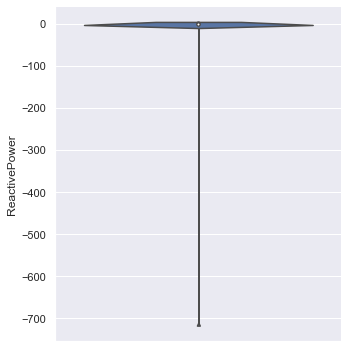

In [16]:
data_distribution(steel_data_arc)   # electrode data

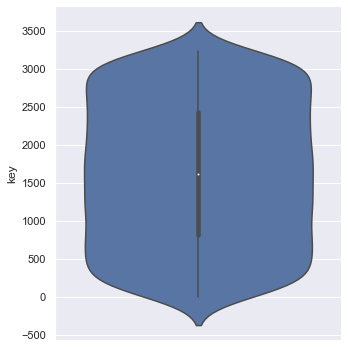

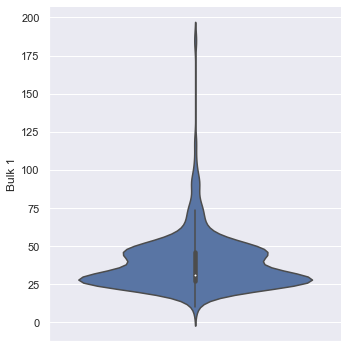

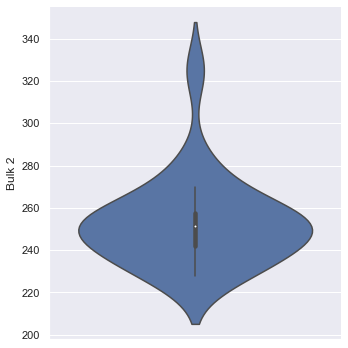

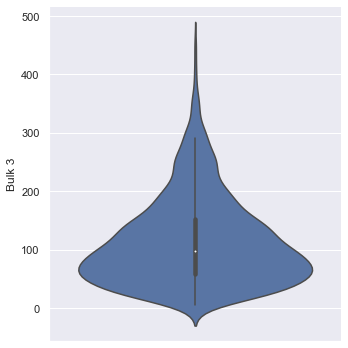

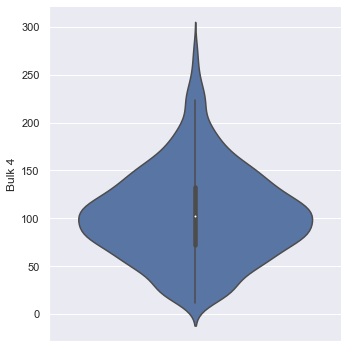

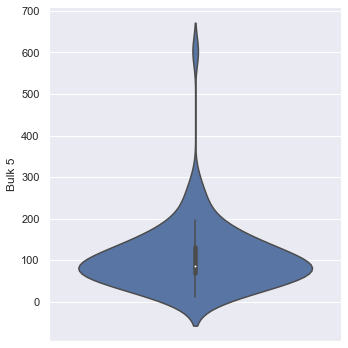

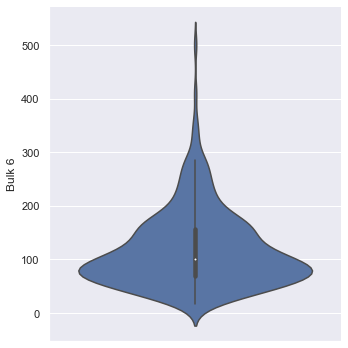

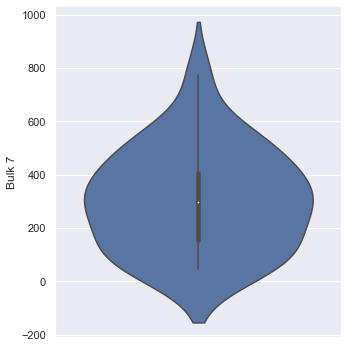

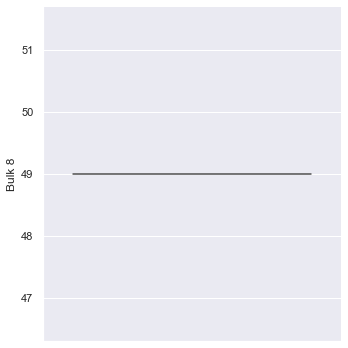

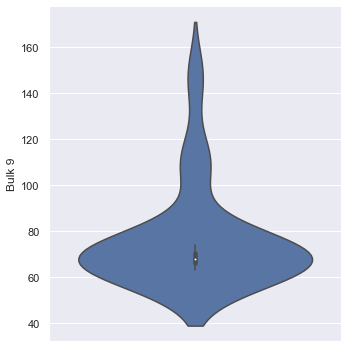

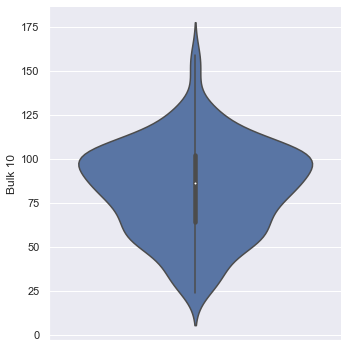

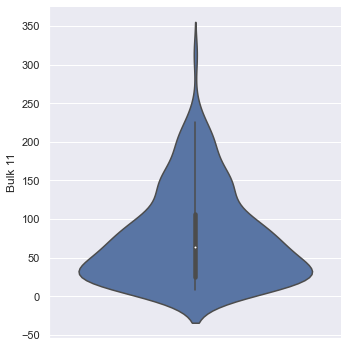

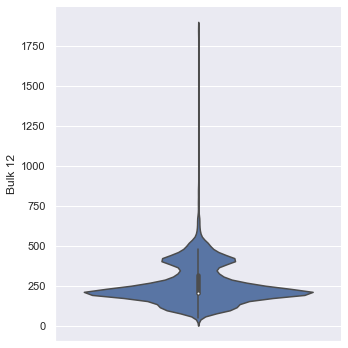

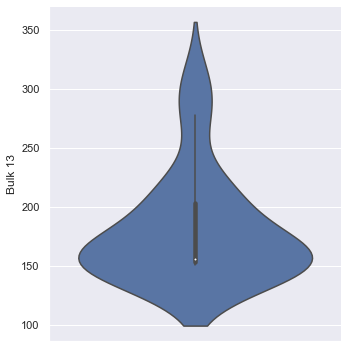

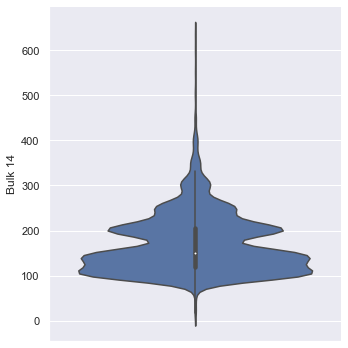

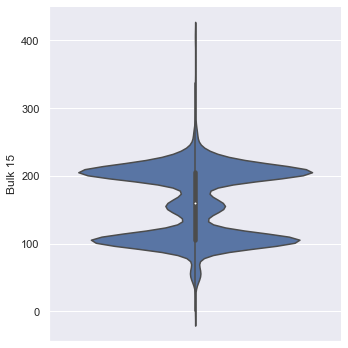

In [17]:
data_distribution(steel_data_bulk)   # bulk material feed data (volume)

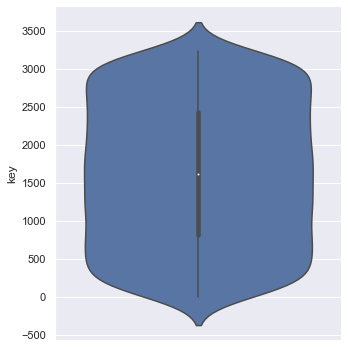

In [18]:
data_distribution(steel_data_bulk_time)   # bulk material feed data (time)

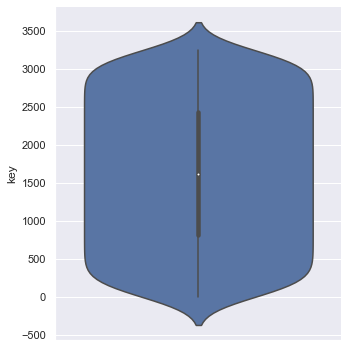

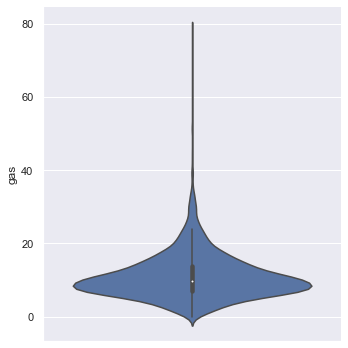

In [19]:
data_distribution(steel_data_gas)   # alloy gas purge data

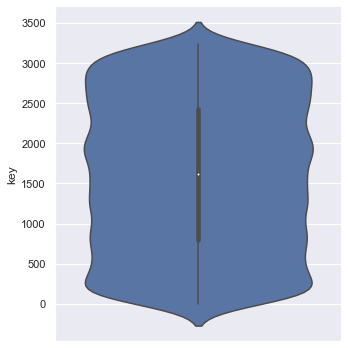

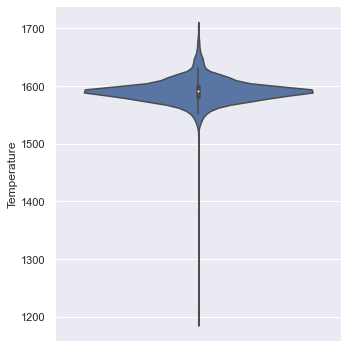

In [20]:
data_distribution(steel_data_temp)   # temperature measurement results

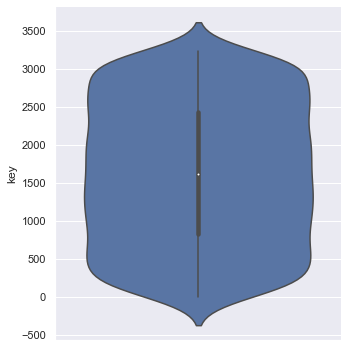

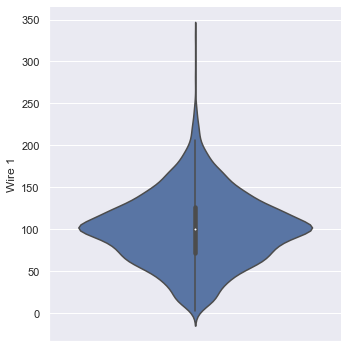

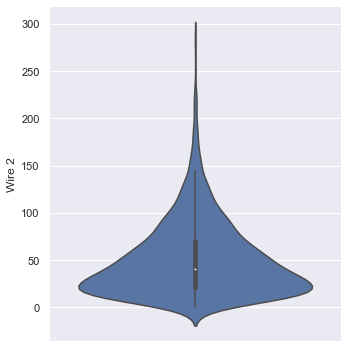

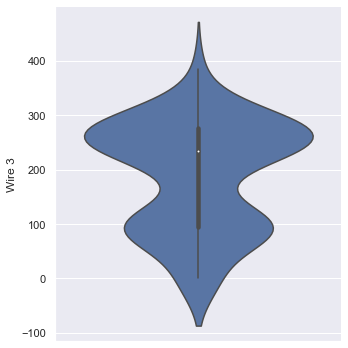

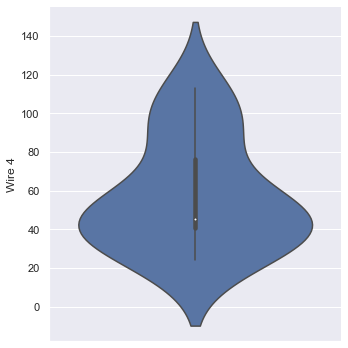

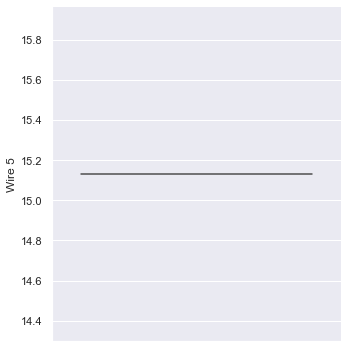

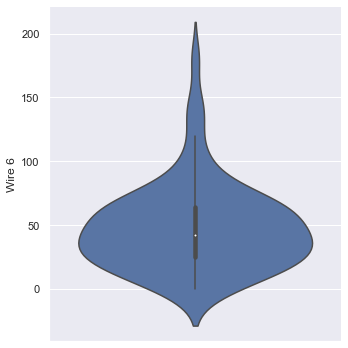

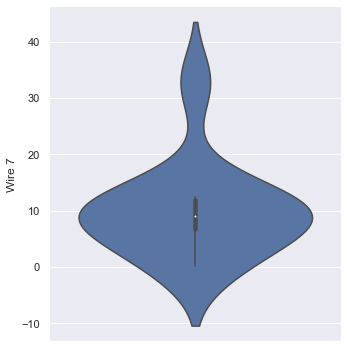

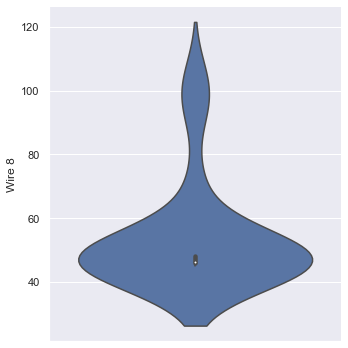

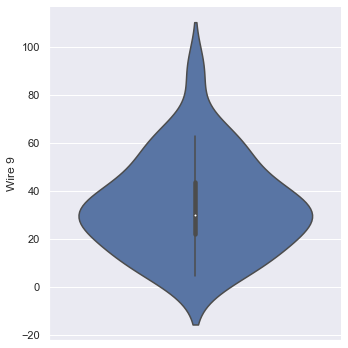

In [21]:
data_distribution(steel_data_wire)   # wire materials data (volume)

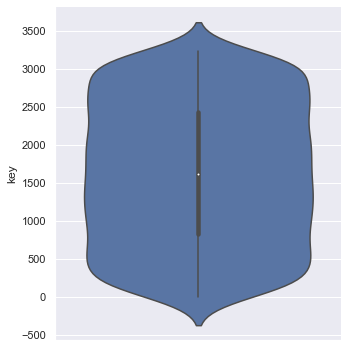

In [22]:
data_distribution(steel_data_wire_time)   # wire material data (time)

In [23]:
for i in tab_list:
   display(i.corr(method='spearman'))

,key,ActivePower,ReactivePower
key,1.000000,-0.023306,-0.002292
ActivePower,-0.023306,1.000000,0.969373
ReactivePower,-0.002292,0.969373,1.000000


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,1.000000,-0.199054,0.199548,-0.058250,-0.079591,0.032005,-0.090141,-0.073077,NaN,0.338823,0.264832,-0.145864,0.029985,-0.025907,-0.190049,-0.007507
Bulk 1,-0.199054,1.000000,-0.124102,-0.048109,0.066050,-0.553421,0.235200,-0.073665,NaN,NaN,-0.536745,-0.028989,0.117537,1.000000,0.247623,-0.110068
Bulk 2,0.199548,-0.124102,1.000000,NaN,0.522282,0.217335,NaN,0.044546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,-0.058250,-0.048109,NaN,1.000000,-0.257777,-0.040016,0.266674,NaN,NaN,0.273976,-0.182979,0.043929,0.035871,-0.461690,0.007240,-0.036229
Bulk 4,-0.079591,0.066050,0.522282,-0.257777,1.000000,0.175876,-0.359092,0.310714,NaN,1.000000,-0.524827,NaN,0.053290,0.144150,0.040015,0.037981
Bulk 5,0.032005,-0.553421,0.217335,-0.040016,0.175876,1.000000,-0.413500,0.420018,NaN,NaN,NaN,NaN,0.090245,NaN,-0.187879,-0.290369
Bulk 6,-0.090141,0.235200,NaN,0.266674,-0.359092,-0.413500,1.000000,NaN,NaN,NaN,NaN,-0.203744,-0.099749,0.405840,0.146407,-0.019538
Bulk 7,-0.073077,-0.073665,0.044546,NaN,0.310714,0.420018,NaN,1.000000,NaN,NaN,NaN,NaN,0.500000,NaN,1.000000,NaN
Bulk 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,0.338823,NaN,NaN,0.273976,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.176475,NaN,-0.462005,NaN


,key
key,1.0


,key,gas
key,1.000000,-0.025175
gas,-0.025175,1.000000


,key,Temperature
key,1.000000,-0.050719
Temperature,-0.050719,1.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.075619,-0.001253,-0.016947,0.367033,NaN,-0.047345,0.478361,0.618842,0.049790
Wire 1,-0.075619,1.000000,-0.089964,0.653495,0.045455,NaN,-0.371451,0.127273,0.157571,0.093673
Wire 2,-0.001253,-0.089964,1.000000,-0.000501,NaN,NaN,-0.200000,NaN,-0.054573,0.103581
Wire 3,-0.016947,0.653495,-0.000501,1.000000,0.063047,NaN,-0.016964,0.215394,NaN,NaN
Wire 4,0.367033,0.045455,NaN,0.063047,1.000000,NaN,0.391608,-0.600000,NaN,NaN
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,-0.047345,-0.371451,-0.200000,-0.016964,0.391608,NaN,1.000000,-0.395139,NaN,NaN
Wire 7,0.478361,0.127273,NaN,0.215394,-0.600000,NaN,-0.395139,1.000000,NaN,NaN
Wire 8,0.618842,0.157571,-0.054573,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Wire 9,0.049790,0.093673,0.103581,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


,key
key,1.0


**Conclusion**

Nanes are present in large numbers in the data. It can be assumed that in such cells they simply did not measure the time, the supply of alloying material. No anomalies were found in the distribution of the data. Strong linear dependencies were found in the `steel_data_arc` table: ActivePower - ReactivePower. In the `steel.data_bulk` and `steel.data_wire` tables, there are some weak dependencies between the volumes of materials fed.

## Calculation of the time between the first and last temperature measurement

**Filling in the gaps in features with zeros**

In [24]:
steel_data_temp[steel_data_temp.columns.tolist()[:steel_data_temp.shape[1]-1]] = steel_data_temp[
    steel_data_temp.columns.tolist()[:steel_data_temp.shape[1]-1]].fillna(0)

In [25]:
steel_data_temp[steel_data_temp.columns.tolist()[:steel_data_temp.shape[1]-1]].head()

,key,MesaureTime
0,1,11:16:18
1,1,11:25:53
2,1,11:29:11
3,1,11:30:01
4,1,11:30:39


**Deleting batches with missing temperature measurement values**

In [26]:
steel_data_temp.shape

(15907, 3)

In [27]:
# array of key values where temperature was not measured
key_arr = steel_data_temp[steel_data_temp['Temperature'].isna()==True]['key'].unique()

# deleting rows where the temperature was not measured
for i in steel_data_temp['key']:
    if i in key_arr:
        steel_data_temp = steel_data_temp[steel_data_temp['key'] != i]

In [28]:
steel_data_temp.shape

(12267, 3)

In [29]:
first_measure = pd.to_datetime(steel_data_temp.groupby('key')['MesaureTime'].max(), format='%H:%M:%S')
last_measure = pd.to_datetime(steel_data_temp.groupby('key')['MesaureTime'].min(), format='%H:%M:%S')
time_first_last_measure_sec = (first_measure - last_measure).apply(lambda x: x.total_seconds())
time_first_last_measure_min = (first_measure - last_measure).apply(lambda x: x.total_seconds() // 60)

In [30]:
steel_data_temp = steel_data_temp.set_index('key')

In [31]:
steel_data_temp['first_measure'] = first_measure
steel_data_temp['last_measure'] = last_measure
steel_data_temp['time_first_last_measure_sec'] = time_first_last_measure_sec
steel_data_temp['time_first_last_measure_min'] = time_first_last_measure_min

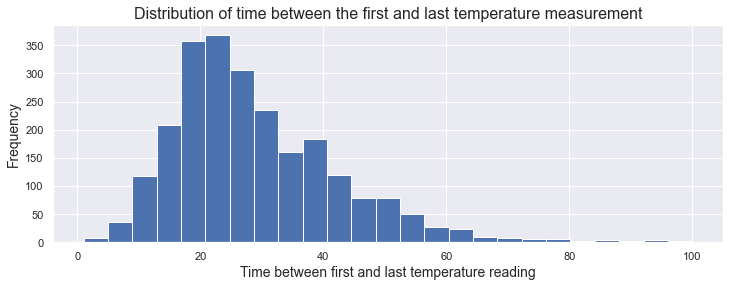

In [32]:
time_first_last_measure_min.hist(bins=25, range=(1, 100), figsize=(12, 4)).set_title(
    'Distribution of time between the first and last temperature measurement', fontsize=16)
plt.xlabel('Time between first and last temperature reading', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

Generally, the time between the first and last temperature reading is 22 minutes.

In [33]:
pd.DataFrame(time_first_last_measure_sec)[pd.DataFrame(time_first_last_measure_sec
                          )['MesaureTime']==0].count()   # the number of zeros in the sample. It means that
                                                         # measurement was taken once

MesaureTime    2
dtype: int64

In [34]:
pd.DataFrame(time_first_last_measure_sec)[pd.DataFrame(time_first_last_measure_sec
                          )['MesaureTime']==0].count() / time_first_last_measure_sec.count() * 100

MesaureTime    0.080743
dtype: float64

2 zero values in the sample

In [35]:
steel_data_temp = steel_data_temp[steel_data_temp['time_first_last_measure_sec']!=0]

In [36]:
steel_data_temp

,MesaureTime,Temperature,first_measure,last_measure,time_first_last_measure_sec,time_first_last_measure_min
key,,,,,,
1,11:16:18,1571.0,1900-01-01 11:30:39,1900-01-01 11:16:18,861.0,14.0
1,11:25:53,1604.0,1900-01-01 11:30:39,1900-01-01 11:16:18,861.0,14.0
1,11:29:11,1618.0,1900-01-01 11:30:39,1900-01-01 11:16:18,861.0,14.0
1,11:30:01,1601.0,1900-01-01 11:30:39,1900-01-01 11:16:18,861.0,14.0
1,11:30:39,1613.0,1900-01-01 11:30:39,1900-01-01 11:16:18,861.0,14.0
...,...,...,...,...,...,...
2498,02:19:26,1593.0,1900-01-01 02:25:31,1900-01-01 02:03:49,1302.0,21.0
2498,02:25:31,1594.0,1900-01-01 02:25:31,1900-01-01 02:03:49,1302.0,21.0
2499,02:40:25,1569.0,1900-01-01 03:00:28,1900-01-01 02:40:25,1203.0,20.0


In [37]:
time_first_last_measure_sec

key
1        861.0
2       1305.0
3       1300.0
4        388.0
5        762.0
         ...  
2495    1137.0
2496    1618.0
2497     717.0
2498    1302.0
2499    1203.0
Name: MesaureTime, Length: 2477, dtype: float64

## Calculation of the total time of heating by electrodes

In [38]:
steel_data_arc['begin_heat_time'] = pd.to_datetime(steel_data_arc.BeginHeat, format='%H:%M:%S')
steel_data_arc['end_heat_time'] = pd.to_datetime(steel_data_arc.EndHeat, format='%H:%M:%S')
steel_data_arc['sum_time_heating_sec'] = (steel_data_arc['end_heat_time'] - steel_data_arc['begin_heat_time']).apply(lambda x: x.total_seconds())
steel_data_arc['sum_time_heating_min'] = (steel_data_arc['end_heat_time'] - steel_data_arc['begin_heat_time']).apply(lambda x: x.total_seconds() // 60)

In [39]:
steel_data_arc['sum_time_heating_sec'].sort_values().head(30)

1170    -86330.0
7864    -86298.0
3438    -86293.0
9513    -86275.0
7233    -86262.0
580     -86260.0
11328   -86247.0
12136   -86247.0
12867   -86218.0
12750   -86218.0
4250    -86208.0
6986    -86205.0
1953    -86196.0
10199   -86184.0
6456    -86128.0
1280    -86114.0
6840    -86103.0
9911    -86094.0
12545   -86093.0
5400    -86058.0
4752    -85917.0
2952    -85782.0
4915        11.0
7372        11.0
6591        11.0
5321        11.0
9163        11.0
11802       11.0
4064        11.0
5597        11.0
Name: sum_time_heating_sec, dtype: float64

The data contains negative values. The time difference cannot be negative. This suggests that there are anomalies in the data that need to be eliminated.

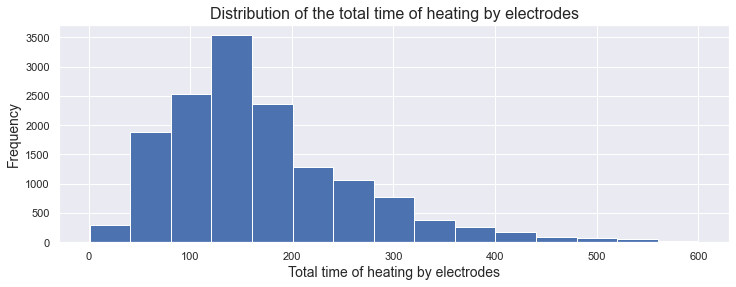

In [40]:
steel_data_arc['sum_time_heating_sec'].hist(bins=15, range=(1, 600), figsize=(12, 4)).set_title(
    'Distribution of the total time of heating by electrodes', fontsize=16)
plt.xlabel('Total time of heating by electrodes', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

If zero and negative values are not taken into account, then the median value of the total heating time by the electrodes fluctuates around 150 seconds.

In [41]:
steel_data_arc['sum_time_heating_sec'].count()

14876

In [42]:
steel_data_arc['sum_time_heating_sec'].loc[steel_data_arc['sum_time_heating_sec'] >= 0].count() 

14854

Remove negative and zero data

In [43]:
steel_data_arc['sum_time_heating_sec_cleaned'] = steel_data_arc['sum_time_heating_sec'].loc[steel_data_arc['sum_time_heating_sec'] > 0]

In [44]:
time_heating_stat = pd.DataFrame({'sum_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].sum(), 
              'mean_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].mean(),
              'min_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].min(),
              'max_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].max(),
              'median_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].median(),
              'quantile_25_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].quantile(.25),
              'quantile_75_time_heating': steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].quantile(.75)
             })

In [45]:
sum_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].sum()
mean_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].mean()
min_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].min()
max_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].max()
median_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].median()
quantile_25_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].quantile(.25)
quantile_75_time_heating = steel_data_arc.groupby('key')['sum_time_heating_sec_cleaned'].quantile(.75)

In [46]:
time_heating_stat

,sum_time_heating,mean_time_heating,min_time_heating,max_time_heating,median_time_heating,quantile_25_time_heating,quantile_75_time_heating
key,,,,,,,
1,1098.0,219.60,148.0,365.0,185.0,172.00,228.00
2,811.0,202.75,126.0,338.0,173.5,134.25,242.00
3,655.0,131.00,65.0,280.0,109.0,77.00,124.00
4,741.0,185.25,99.0,278.0,182.0,142.50,224.75
5,869.0,217.25,71.0,415.0,191.5,116.75,292.00
...,...,...,...,...,...,...,...
3237,909.0,181.80,119.0,242.0,177.0,136.00,235.00
3238,546.0,182.00,111.0,265.0,170.0,140.50,217.50
3239,1216.0,152.00,53.0,294.0,139.0,121.50,174.75


## Number of electrode heating starts

In [47]:
count_electrode_launches = steel_data_arc.groupby('key')['BeginHeat'].count()

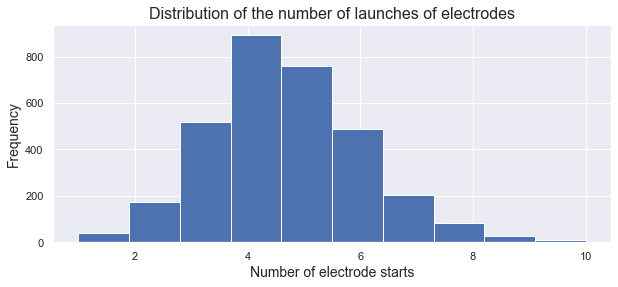

In [48]:
count_electrode_launches.hist(bins=10, range=(1, 10), figsize=(10, 4)
                             ).set_title('Distribution of the number of launches of electrodes', fontsize=16)
plt.xlabel('Number of electrode starts', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

Typically, the number of electrode starts fluctuates around 4.

In [49]:
count_electrode_launches

key
1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: BeginHeat, Length: 3214, dtype: int64

## Average ratio of active and reactive power consumption

In [50]:
mean_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].sum() / steel_data_arc.groupby(
    'key')['ReactivePower'].sum()
min_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].min() / steel_data_arc.groupby(
    'key')['ReactivePower'].min()
max_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].max() / steel_data_arc.groupby(
    'key')['ReactivePower'].max()
median_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].median() / steel_data_arc.groupby(
    'key')['ReactivePower'].median()
quantile_25_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].quantile(.25) / steel_data_arc.groupby(
    'key')['ReactivePower'].quantile(.25)
quantile_75_ratio_act_react_power = steel_data_arc.groupby('key')['ActivePower'].quantile(.75) / steel_data_arc.groupby(
    'key')['ReactivePower'].quantile(.75)

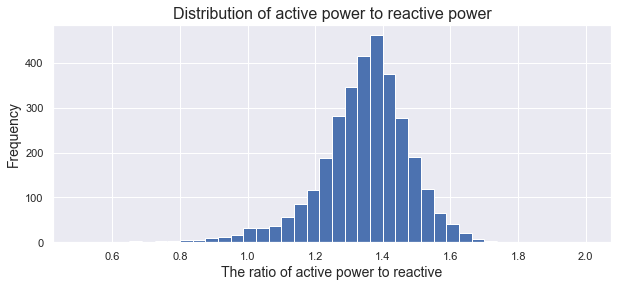

In [51]:
mean_ratio_act_react_power.hist(bins=40, range=(0.5, 2), figsize=(10, 4)
                             ).set_title('Distribution of active power to reactive power', 
                                         fontsize=16)
plt.xlabel('The ratio of active power to reactive', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

On average, the active power is 1.3 times greater than the reactive power.

In [52]:
mean_ratio_act_react_power.sort_values()

key
2116   -0.002587
552     0.609224
2142    0.646375
2743    0.667636
2343    0.670377
          ...   
2918    1.701700
2889    1.716437
1671    1.718755
1419    1.726324
36      1.777119
Length: 3214, dtype: float64

There can be no negative power. Delete these values.

In [53]:
mean_ratio_act_react_power = mean_ratio_act_react_power[mean_ratio_act_react_power > 0]

In [54]:
mean_ratio_act_react_power.sort_values()

key
552     0.609224
2142    0.646375
2743    0.667636
2343    0.670377
2780    0.676752
          ...   
2918    1.701700
2889    1.716437
1671    1.718755
1419    1.726324
36      1.777119
Length: 3213, dtype: float64

In [55]:
ratio_stat_act_react_power = pd.DataFrame({'mean_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].sum() / steel_data_arc.groupby(
    'key')['ReactivePower'].sum(),
             'min_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].min() / steel_data_arc.groupby(
    'key')['ReactivePower'].min(),
            'max_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].max() / steel_data_arc.groupby(
    'key')['ReactivePower'].max(),
            'median_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].median() / steel_data_arc.groupby(
    'key')['ReactivePower'].median(),
            'quantile_25_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].quantile(.25) / steel_data_arc.groupby(
    'key')['ReactivePower'].quantile(.25),
            'quantile_75_ratio_act_react_power': steel_data_arc.groupby('key')['ActivePower'].quantile(.75) / steel_data_arc.groupby(
    'key')['ReactivePower'].quantile(.75)})

In [56]:
ratio_stat_act_react_power

,mean_ratio_act_react_power,min_ratio_act_react_power,max_ratio_act_react_power,median_ratio_act_react_power,quantile_25_ratio_act_react_power,quantile_75_ratio_act_react_power
key,,,,,,
1,1.532447,1.671717,1.561504,1.548395,1.492292,1.420582
2,1.527741,1.547690,1.451893,1.603250,1.592472,1.546793
3,1.579589,1.605373,1.581626,1.579819,1.597337,1.551444
4,1.557663,1.585551,1.617762,1.506709,1.618916,1.480753
5,1.485887,1.469607,1.547721,1.425444,1.519474,1.433552
...,...,...,...,...,...,...
3237,1.390321,1.266061,1.351236,1.444683,1.446127,1.412907
3238,1.253004,1.199154,1.195956,1.378271,1.311448,1.265170
3239,1.499784,1.523542,1.595397,1.386771,1.547402,1.463227


## Active / reactive power statistics

In [57]:
ratio_stat_act_react_power['act_power_sum'] = steel_data_arc.groupby('key')['ActivePower'].sum()
ratio_stat_act_react_power['act_power_max'] = steel_data_arc.groupby('key')['ActivePower'].max()
ratio_stat_act_react_power['act_power_min'] = steel_data_arc.groupby('key')['ActivePower'].min()
ratio_stat_act_react_power['act_power_mean'] = steel_data_arc.groupby('key')['ActivePower'].mean()
ratio_stat_act_react_power['act_power_quan_25'] = steel_data_arc.groupby('key')['ActivePower'].quantile(.25)
ratio_stat_act_react_power['act_power_quan_75'] = steel_data_arc.groupby('key')['ActivePower'].quantile(.75)
ratio_stat_act_react_power['react_power_sum'] = steel_data_arc.groupby('key')['ReactivePower'].sum()
ratio_stat_act_react_power['react_power_max'] = steel_data_arc.groupby('key')['ReactivePower'].max()
ratio_stat_act_react_power['react_power_min'] = steel_data_arc.groupby('key')['ReactivePower'].min()
ratio_stat_act_react_power['react_power_mean'] = steel_data_arc.groupby('key')['ReactivePower'].mean()

## Total amount of bulk materials

In [58]:
steel_data_bulk = steel_data_bulk.fillna(0).set_index('key')

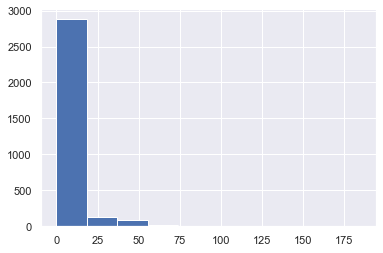

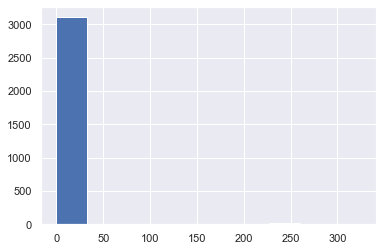

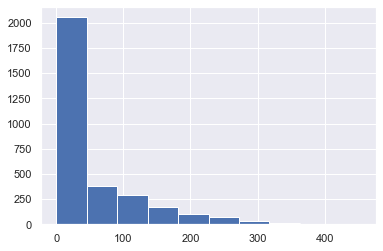

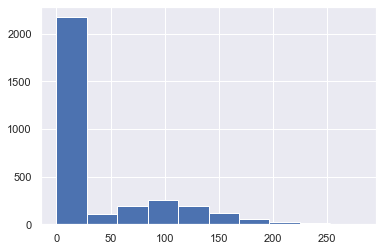

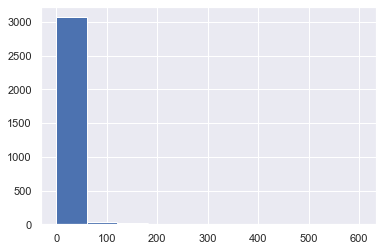

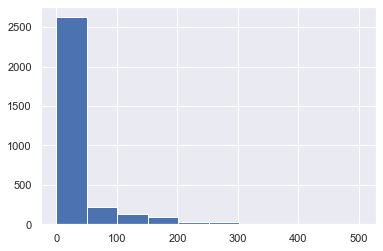

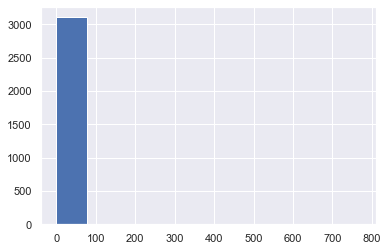

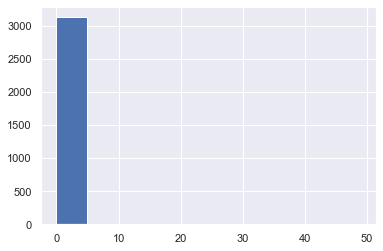

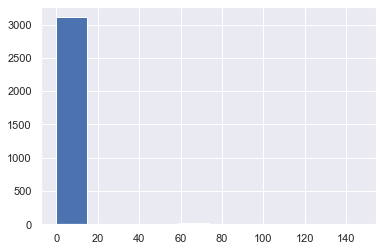

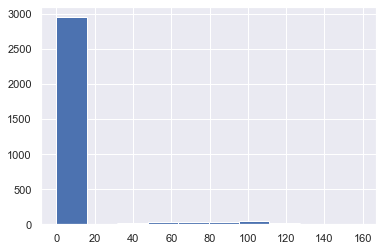

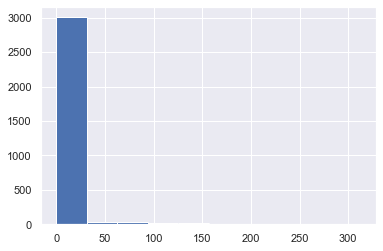

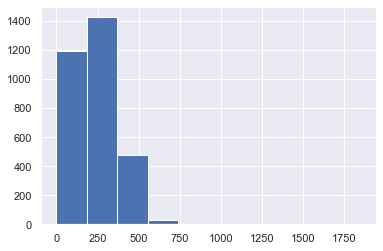

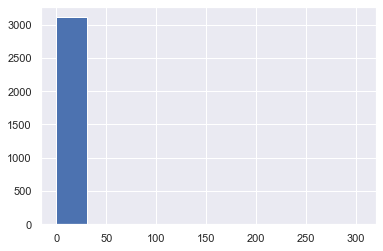

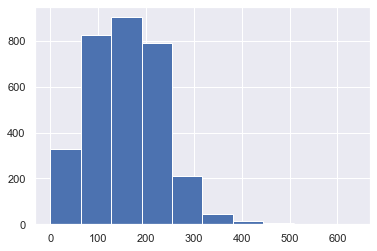

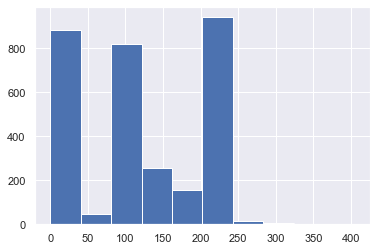

In [59]:
for i in range(steel_data_bulk.shape[1]):
    steel_data_bulk[steel_data_bulk.columns.tolist()[i]].hist()
    plt.show()

In [60]:
steel_data_bulk

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0


## Total amount of wire materials

In [61]:
steel_data_wire = steel_data_wire.fillna(0).set_index('key')

In [62]:
steel_data_wire

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Initial alloy temperature

In [63]:
elementary_alloy_temp = steel_data_temp.reset_index()[steel_data_temp.reset_index().key.duplicated(
    keep='first') != True][['key', 'Temperature']].set_index('key')

In [64]:
elementary_alloy_temp

,Temperature
key,
1,1571.0
2,1581.0
3,1596.0
4,1601.0
5,1576.0
...,...
2495,1570.0
2496,1554.0
2497,1571.0


## The volume of supplied gas

In [65]:
steel_data_gas = steel_data_gas.set_index('key')

In [66]:
steel_data_gas 

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


## Formation of feature space

### Features

In [67]:
ratio_stat_act_react_power['time_first_last_measure_sec'] = time_first_last_measure_sec

In [68]:
input_df = ratio_stat_act_react_power.join(time_heating_stat)

In [69]:
input_df = input_df.join(steel_data_bulk)

In [70]:
input_df = input_df.join(steel_data_wire)

In [71]:
input_df['count_electrode_launches'] = count_electrode_launches
input_df['elementary_alloy_temp'] = elementary_alloy_temp
input_df['steel_data_gas'] = steel_data_gas 

In [72]:
input_df

,mean_ratio_act_react_power,min_ratio_act_react_power,max_ratio_act_react_power,median_ratio_act_react_power,quantile_25_ratio_act_react_power,quantile_75_ratio_act_react_power,act_power_sum,act_power_max,act_power_min,act_power_mean,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,count_electrode_launches,elementary_alloy_temp,steel_data_gas
key,,,,,,,,,,,,,,,,,,,,,
1,1.532447,1.671717,1.561504,1.548395,1.492292,1.420582,4.878147,1.659363,0.692755,0.975629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1571.0,29.749986
2,1.527741,1.547690,1.451893,1.603250,1.592472,1.546793,3.052598,1.296415,0.438063,0.763150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1581.0,12.555561
3,1.579589,1.605373,1.581626,1.579819,1.597337,1.551444,2.525882,1.062053,0.250280,0.505176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1596.0,28.554793
4,1.557663,1.585551,1.617762,1.506709,1.618916,1.480753,3.209250,1.220955,0.425692,0.802313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1601.0,18.841219
5,1.485887,1.469607,1.547721,1.425444,1.519474,1.433552,3.347173,1.621665,0.267457,0.836793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1576.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,1.390321,1.266061,1.351236,1.444683,1.446127,1.412907,3.932467,1.060122,0.405685,0.786493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,NaN,5.543905
3238,1.253004,1.199154,1.195956,1.378271,1.311448,1.265170,2.106529,1.017459,0.371511,0.702176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN,6.745669
3239,1.499784,1.523542,1.595397,1.386771,1.547402,1.463227,4.666754,1.156764,0.205792,0.583344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,NaN,16.023518


### Target feature

In [73]:
steel_data_temp_indx = steel_data_temp.reset_index()

In [74]:
last_temp = steel_data_temp_indx[steel_data_temp_indx.key.duplicated(keep='last') != True]

In [75]:
last_temp = last_temp.set_index('key')

In [76]:
target = last_temp['Temperature']

In [77]:
target

key
1       1613.0
2       1602.0
3       1599.0
4       1625.0
5       1602.0
         ...  
2495    1591.0
2496    1591.0
2497    1589.0
2498    1594.0
2499    1603.0
Name: Temperature, Length: 2475, dtype: float64

In [78]:
input_df['target'] = target

In [79]:
phik_overview = input_df.phik_matrix()

interval columns not set, guessing: ['mean_ratio_act_react_power', 'min_ratio_act_react_power', 'max_ratio_act_react_power', 'median_ratio_act_react_power', 'quantile_25_ratio_act_react_power', 'quantile_75_ratio_act_react_power', 'act_power_sum', 'act_power_max', 'act_power_min', 'act_power_mean', 'act_power_quan_25', 'act_power_quan_75', 'react_power_sum', 'react_power_max', 'react_power_min', 'react_power_mean', 'time_first_last_measure_sec', 'sum_time_heating', 'mean_time_heating', 'min_time_heating', 'max_time_heating', 'median_time_heating', 'quantile_25_time_heating', 'quantile_75_time_heating', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'count_electrode_launches', 'elementary_alloy_temp', 'steel_data_gas', 'target']


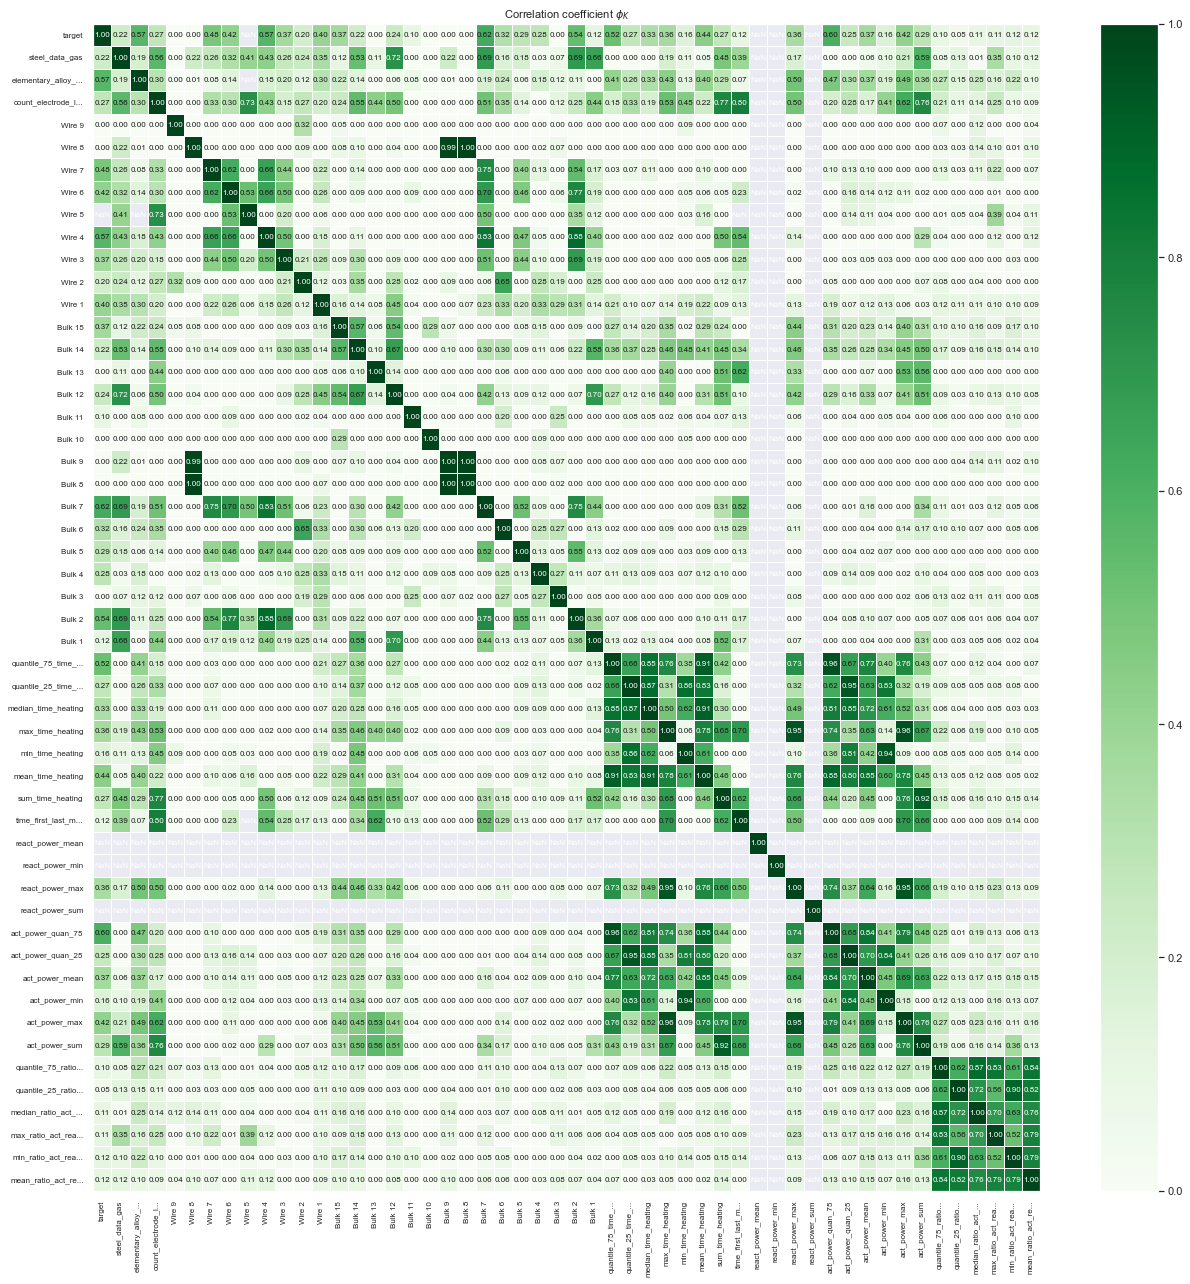

In [80]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation coefficient $\phi_K$",
                        fontsize_factor=0.8, 
                        figsize=(18, 18))
plt.tight_layout()

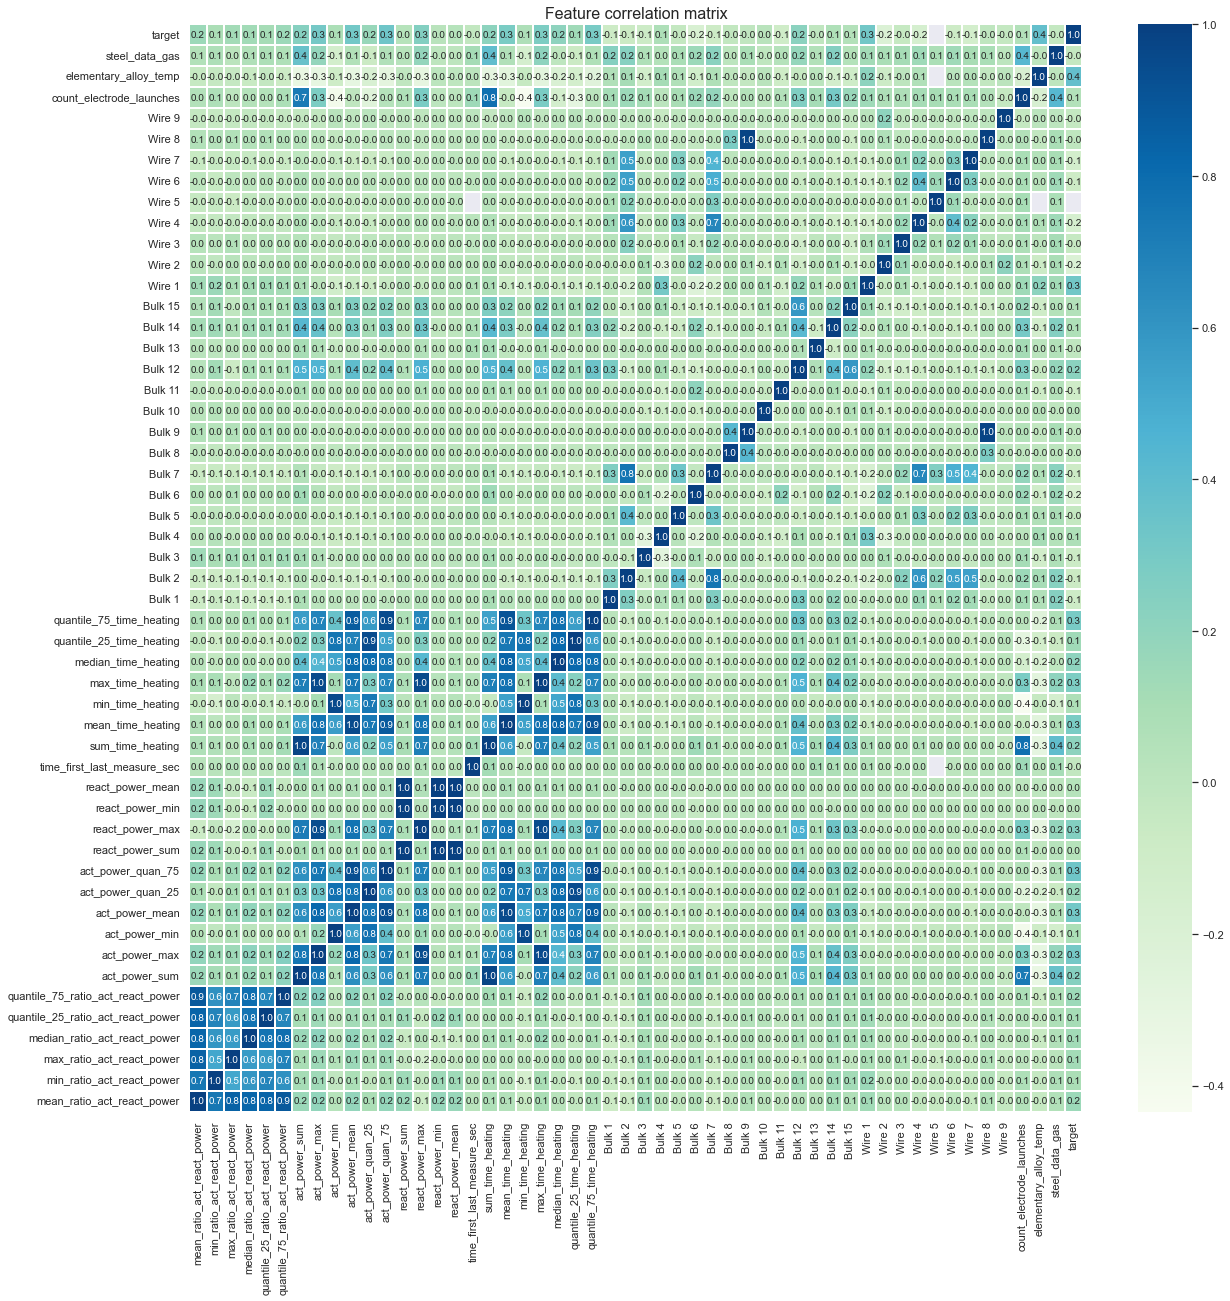

In [81]:
f, ax = plt.subplots(figsize=(20, 20))
g = sns.heatmap(input_df.corr()[::-1], fmt='.1f', annot=True, linewidths=.1, ax=ax, cmap='GnBu', annot_kws={"fontsize": 10})
plt.title('Feature correlation matrix', fontsize=16)
plt.show()

In [82]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mean_ratio_act_react_power         3214 non-null   float64
 1   min_ratio_act_react_power          3214 non-null   float64
 2   max_ratio_act_react_power          3214 non-null   float64
 3   median_ratio_act_react_power       3214 non-null   float64
 4   quantile_25_ratio_act_react_power  3214 non-null   float64
 5   quantile_75_ratio_act_react_power  3214 non-null   float64
 6   act_power_sum                      3214 non-null   float64
 7   act_power_max                      3214 non-null   float64
 8   act_power_min                      3214 non-null   float64
 9   act_power_mean                     3214 non-null   float64
 10  act_power_quan_25                  3214 non-null   float64
 11  act_power_quan_75                  3214 non-null   float

In [83]:
input_df = input_df.dropna()

In [84]:
input_df.shape

(2329, 52)

In [85]:
features = input_df.drop(['target', 
                          'Bulk 7', 
                          'Bulk 2', 
                          'max_ratio_act_react_power',
                          'min_ratio_act_react_power', 
                          'median_ratio_act_react_power',
                         'quantile_25_ratio_act_react_power', 
                         'act_power_min', 
                         'act_power_quan_25', 
                         'act_power_quan_75', 
                         'react_power_max', 
                         'react_power_min',
                         'react_power_mean',
                         'react_power_sum'], axis = 1)

target = input_df.target

In [86]:
features.shape

(2329, 38)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) 

# Model training

## Linear regression model

In [88]:
lr = LinearRegression(n_jobs = -1)
pipe = make_pipeline(StandardScaler(), lr)
print('MAE:', np.mean(abs(cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))))

MAE: 6.2393901037798685


## Decision tree model

In [89]:
%%time
dec_tree = DecisionTreeRegressor(random_state=12345)
parametrs = {  
             'max_depth': [3, 4, 5],   
             'min_samples_leaf': [11, 12, 13],   
             'min_samples_split': [2]} 

grid = GridSearchCV(dec_tree, parametrs,
                    cv=5,
                    n_jobs=-1,
                    scoring='neg_mean_absolute_error',
                    verbose=3)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 375 ms


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_samples_leaf': [11, 12, 13],
                         'min_samples_split': [2]},
             scoring='neg_mean_absolute_error', verbose=3)

In [90]:
grid.best_score_

-6.874819240914154

In [91]:
grid.best_params_

{'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split': 2}

## Gradient boosting model

In [92]:
%%time

grid = {'iterations': range(500, 600, 100),
        'learning_rate': [0.1, 0.5, 0.01, 0.05],
       }
ctb = CatBoostRegressor(grow_policy='SymmetricTree',
                           random_state=35,
                           verbose=1,
                           loss_function='MAE', 
                           eval_metric='MAE')

grid_search_result = ctb.grid_search(grid,                                    
                                       X=X_train, 
                                       y=y_train,
                                       cv=5,
                                       partition_random_seed=1,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       train_size=0.75,
                                       refit=True,
                                       verbose=False,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1434.2071013	test: 1435.1441614	best: 1435.1441614 (0)	total: 160ms	remaining: 1m 20s
1:	learn: 1290.8488306	test: 1292.4187105	best: 1292.4187105 (1)	total: 162ms	remaining: 40.4s
2:	learn: 1161.8260331	test: 1163.9625251	best: 1163.9625251 (2)	total: 164ms	remaining: 27.2s
3:	learn: 1045.7526251	test: 1047.8960824	best: 1047.8960824 (3)	total: 166ms	remaining: 20.6s
4:	learn: 941.2522950	test: 943.3958710	best: 943.3958710 (4)	total: 168ms	remaining: 16.6s
5:	learn: 847.2053321	test: 849.9547706	best: 849.9547706 (5)	total: 169ms	remaining: 13.9s
6:	learn: 762.5654265	test: 765.7101259	best: 765.7101259 (6)	total: 171ms	remaining: 12.1s
7:	learn: 686.3922526	test: 689.5240452	best: 689.5240452 (7)	total: 173ms	remaining: 10.6s
8:	learn: 617.8603188	test: 620.9663960	best: 620.9663960 (8)	total: 175ms	remaining: 9.54s
9:	learn: 556.1735834	test: 559.4312088	best: 559.4312088 (9)	total: 177ms	remaining: 8.66s
10:	learn: 500.6686775	test: 504.3052781	best: 504.3052781 (10)	tot

97:	learn: 4.3698420	test: 10.1035235	best: 10.1024131 (96)	total: 335ms	remaining: 1.38s
98:	learn: 4.3513624	test: 10.1061370	best: 10.1024131 (96)	total: 337ms	remaining: 1.36s
99:	learn: 4.3225106	test: 10.0868401	best: 10.0868401 (99)	total: 339ms	remaining: 1.36s
100:	learn: 4.2998757	test: 10.0895362	best: 10.0868401 (99)	total: 341ms	remaining: 1.35s
101:	learn: 4.2722905	test: 10.0897735	best: 10.0868401 (99)	total: 343ms	remaining: 1.34s
102:	learn: 4.2563711	test: 10.0939450	best: 10.0868401 (99)	total: 345ms	remaining: 1.33s
103:	learn: 4.2342046	test: 10.0981039	best: 10.0868401 (99)	total: 346ms	remaining: 1.32s
104:	learn: 4.2125358	test: 10.0962320	best: 10.0868401 (99)	total: 348ms	remaining: 1.31s
105:	learn: 4.1828815	test: 10.0949710	best: 10.0868401 (99)	total: 350ms	remaining: 1.3s
106:	learn: 4.1628383	test: 10.1041131	best: 10.0868401 (99)	total: 352ms	remaining: 1.29s
107:	learn: 4.1490495	test: 10.1016386	best: 10.0868401 (99)	total: 354ms	remaining: 1.28s
108

194:	learn: 2.9857563	test: 10.0602927	best: 10.0384164 (148)	total: 515ms	remaining: 806ms
195:	learn: 2.9786534	test: 10.0618758	best: 10.0384164 (148)	total: 517ms	remaining: 802ms
196:	learn: 2.9733108	test: 10.0643099	best: 10.0384164 (148)	total: 519ms	remaining: 798ms
197:	learn: 2.9709034	test: 10.0645073	best: 10.0384164 (148)	total: 521ms	remaining: 794ms
198:	learn: 2.9635462	test: 10.0563831	best: 10.0384164 (148)	total: 524ms	remaining: 792ms
199:	learn: 2.9583598	test: 10.0582748	best: 10.0384164 (148)	total: 526ms	remaining: 789ms
200:	learn: 2.9524940	test: 10.0551749	best: 10.0384164 (148)	total: 528ms	remaining: 785ms
201:	learn: 2.9435867	test: 10.0578838	best: 10.0384164 (148)	total: 530ms	remaining: 781ms
202:	learn: 2.9395150	test: 10.0503456	best: 10.0384164 (148)	total: 532ms	remaining: 778ms
203:	learn: 2.9340917	test: 10.0466577	best: 10.0384164 (148)	total: 534ms	remaining: 774ms
204:	learn: 2.9269378	test: 10.0430670	best: 10.0384164 (148)	total: 536ms	remai

290:	learn: 2.4654984	test: 10.0387265	best: 10.0383866 (289)	total: 693ms	remaining: 498ms
291:	learn: 2.4576192	test: 10.0450841	best: 10.0383866 (289)	total: 695ms	remaining: 495ms
292:	learn: 2.4547534	test: 10.0470498	best: 10.0383866 (289)	total: 697ms	remaining: 492ms
293:	learn: 2.4510183	test: 10.0454173	best: 10.0383866 (289)	total: 699ms	remaining: 489ms
294:	learn: 2.4423809	test: 10.0455145	best: 10.0383866 (289)	total: 700ms	remaining: 487ms
295:	learn: 2.4401650	test: 10.0450842	best: 10.0383866 (289)	total: 702ms	remaining: 484ms
296:	learn: 2.4348244	test: 10.0415051	best: 10.0383866 (289)	total: 704ms	remaining: 481ms
297:	learn: 2.4297340	test: 10.0404282	best: 10.0383866 (289)	total: 706ms	remaining: 478ms
298:	learn: 2.4254817	test: 10.0406428	best: 10.0383866 (289)	total: 708ms	remaining: 476ms
299:	learn: 2.4201956	test: 10.0408166	best: 10.0383866 (289)	total: 710ms	remaining: 473ms
300:	learn: 2.4173092	test: 10.0434506	best: 10.0383866 (289)	total: 712ms	remai

385:	learn: 2.1648720	test: 10.0662388	best: 10.0383866 (289)	total: 870ms	remaining: 257ms
386:	learn: 2.1624722	test: 10.0655332	best: 10.0383866 (289)	total: 872ms	remaining: 255ms
387:	learn: 2.1599576	test: 10.0647034	best: 10.0383866 (289)	total: 874ms	remaining: 252ms
388:	learn: 2.1576004	test: 10.0648269	best: 10.0383866 (289)	total: 876ms	remaining: 250ms
389:	learn: 2.1562318	test: 10.0650563	best: 10.0383866 (289)	total: 878ms	remaining: 248ms
390:	learn: 2.1531478	test: 10.0658193	best: 10.0383866 (289)	total: 880ms	remaining: 245ms
391:	learn: 2.1521208	test: 10.0660648	best: 10.0383866 (289)	total: 882ms	remaining: 243ms
392:	learn: 2.1500450	test: 10.0652741	best: 10.0383866 (289)	total: 884ms	remaining: 241ms
393:	learn: 2.1472275	test: 10.0642558	best: 10.0383866 (289)	total: 886ms	remaining: 238ms
394:	learn: 2.1448472	test: 10.0644129	best: 10.0383866 (289)	total: 888ms	remaining: 236ms
395:	learn: 2.1437306	test: 10.0644865	best: 10.0383866 (289)	total: 889ms	remai

482:	learn: 1.9798254	test: 10.0828154	best: 10.0383866 (289)	total: 1.05s	remaining: 36.9ms
483:	learn: 1.9791233	test: 10.0828796	best: 10.0383866 (289)	total: 1.05s	remaining: 34.7ms
484:	learn: 1.9787161	test: 10.0828972	best: 10.0383866 (289)	total: 1.05s	remaining: 32.6ms
485:	learn: 1.9767975	test: 10.0826497	best: 10.0383866 (289)	total: 1.05s	remaining: 30.4ms
486:	learn: 1.9749470	test: 10.0829838	best: 10.0383866 (289)	total: 1.06s	remaining: 28.2ms
487:	learn: 1.9719091	test: 10.0819169	best: 10.0383866 (289)	total: 1.06s	remaining: 26ms
488:	learn: 1.9684671	test: 10.0801414	best: 10.0383866 (289)	total: 1.06s	remaining: 23.8ms
489:	learn: 1.9646152	test: 10.0806712	best: 10.0383866 (289)	total: 1.06s	remaining: 21.7ms
490:	learn: 1.9643361	test: 10.0804593	best: 10.0383866 (289)	total: 1.06s	remaining: 19.5ms
491:	learn: 1.9630749	test: 10.0795179	best: 10.0383866 (289)	total: 1.06s	remaining: 17.3ms
492:	learn: 1.9618505	test: 10.0796664	best: 10.0383866 (289)	total: 1.0

75:	learn: 2.4134294	test: 12.6130506	best: 12.4247405 (19)	total: 146ms	remaining: 812ms
76:	learn: 2.4048988	test: 12.6173836	best: 12.4247405 (19)	total: 148ms	remaining: 811ms
77:	learn: 2.3949352	test: 12.6184226	best: 12.4247405 (19)	total: 149ms	remaining: 809ms
78:	learn: 2.3747242	test: 12.6104579	best: 12.4247405 (19)	total: 151ms	remaining: 806ms
79:	learn: 2.3643992	test: 12.6014055	best: 12.4247405 (19)	total: 153ms	remaining: 804ms
80:	learn: 2.3487390	test: 12.5962561	best: 12.4247405 (19)	total: 155ms	remaining: 802ms
81:	learn: 2.3233862	test: 12.5745137	best: 12.4247405 (19)	total: 157ms	remaining: 799ms
82:	learn: 2.3122204	test: 12.5686996	best: 12.4247405 (19)	total: 159ms	remaining: 796ms
83:	learn: 2.2930490	test: 12.5627374	best: 12.4247405 (19)	total: 160ms	remaining: 794ms
84:	learn: 2.2749448	test: 12.5677996	best: 12.4247405 (19)	total: 162ms	remaining: 792ms
85:	learn: 2.2591325	test: 12.5680439	best: 12.4247405 (19)	total: 164ms	remaining: 789ms
86:	learn:

172:	learn: 1.6091749	test: 12.5604733	best: 12.4247405 (19)	total: 324ms	remaining: 613ms
173:	learn: 1.6004954	test: 12.5647012	best: 12.4247405 (19)	total: 326ms	remaining: 611ms
174:	learn: 1.5937677	test: 12.5555476	best: 12.4247405 (19)	total: 328ms	remaining: 609ms
175:	learn: 1.5863485	test: 12.5529564	best: 12.4247405 (19)	total: 330ms	remaining: 607ms
176:	learn: 1.5821049	test: 12.5489483	best: 12.4247405 (19)	total: 332ms	remaining: 605ms
177:	learn: 1.5780586	test: 12.5501321	best: 12.4247405 (19)	total: 334ms	remaining: 603ms
178:	learn: 1.5716501	test: 12.5438481	best: 12.4247405 (19)	total: 335ms	remaining: 601ms
179:	learn: 1.5613744	test: 12.5442596	best: 12.4247405 (19)	total: 337ms	remaining: 599ms
180:	learn: 1.5584047	test: 12.5454470	best: 12.4247405 (19)	total: 339ms	remaining: 598ms
181:	learn: 1.5557744	test: 12.5519229	best: 12.4247405 (19)	total: 341ms	remaining: 596ms
182:	learn: 1.5551987	test: 12.5517951	best: 12.4247405 (19)	total: 343ms	remaining: 594ms

267:	learn: 1.2602619	test: 12.6089524	best: 12.4247405 (19)	total: 503ms	remaining: 435ms
268:	learn: 1.2571647	test: 12.6081399	best: 12.4247405 (19)	total: 505ms	remaining: 434ms
269:	learn: 1.2565446	test: 12.6082939	best: 12.4247405 (19)	total: 507ms	remaining: 432ms
270:	learn: 1.2552893	test: 12.6098872	best: 12.4247405 (19)	total: 508ms	remaining: 430ms
271:	learn: 1.2528633	test: 12.6066209	best: 12.4247405 (19)	total: 510ms	remaining: 428ms
272:	learn: 1.2515300	test: 12.6071628	best: 12.4247405 (19)	total: 512ms	remaining: 426ms
273:	learn: 1.2509991	test: 12.6072727	best: 12.4247405 (19)	total: 514ms	remaining: 424ms
274:	learn: 1.2433909	test: 12.6093334	best: 12.4247405 (19)	total: 516ms	remaining: 422ms
275:	learn: 1.2420046	test: 12.6079113	best: 12.4247405 (19)	total: 518ms	remaining: 421ms
276:	learn: 1.2412417	test: 12.6078708	best: 12.4247405 (19)	total: 520ms	remaining: 419ms
277:	learn: 1.2401897	test: 12.6055002	best: 12.4247405 (19)	total: 522ms	remaining: 417ms

364:	learn: 1.0738677	test: 12.6687548	best: 12.4247405 (19)	total: 682ms	remaining: 252ms
365:	learn: 1.0734842	test: 12.6684916	best: 12.4247405 (19)	total: 684ms	remaining: 250ms
366:	learn: 1.0727801	test: 12.6678109	best: 12.4247405 (19)	total: 686ms	remaining: 249ms
367:	learn: 1.0716755	test: 12.6686312	best: 12.4247405 (19)	total: 688ms	remaining: 247ms
368:	learn: 1.0713959	test: 12.6686388	best: 12.4247405 (19)	total: 690ms	remaining: 245ms
369:	learn: 1.0703045	test: 12.6686376	best: 12.4247405 (19)	total: 691ms	remaining: 243ms
370:	learn: 1.0697332	test: 12.6697465	best: 12.4247405 (19)	total: 693ms	remaining: 241ms
371:	learn: 1.0692729	test: 12.6697337	best: 12.4247405 (19)	total: 695ms	remaining: 239ms
372:	learn: 1.0682607	test: 12.6703594	best: 12.4247405 (19)	total: 697ms	remaining: 237ms
373:	learn: 1.0665328	test: 12.6678213	best: 12.4247405 (19)	total: 699ms	remaining: 235ms
374:	learn: 1.0661008	test: 12.6678725	best: 12.4247405 (19)	total: 700ms	remaining: 233ms

463:	learn: 0.9574340	test: 12.6538435	best: 12.4247405 (19)	total: 860ms	remaining: 66.7ms
464:	learn: 0.9496317	test: 12.6509413	best: 12.4247405 (19)	total: 862ms	remaining: 64.9ms
465:	learn: 0.9483651	test: 12.6508632	best: 12.4247405 (19)	total: 864ms	remaining: 63ms
466:	learn: 0.9477632	test: 12.6490571	best: 12.4247405 (19)	total: 866ms	remaining: 61.2ms
467:	learn: 0.9466051	test: 12.6473069	best: 12.4247405 (19)	total: 869ms	remaining: 59.4ms
468:	learn: 0.9463248	test: 12.6472295	best: 12.4247405 (19)	total: 870ms	remaining: 57.5ms
469:	learn: 0.9460250	test: 12.6470338	best: 12.4247405 (19)	total: 872ms	remaining: 55.7ms
470:	learn: 0.9444474	test: 12.6468368	best: 12.4247405 (19)	total: 874ms	remaining: 53.8ms
471:	learn: 0.9438755	test: 12.6479320	best: 12.4247405 (19)	total: 876ms	remaining: 52ms
472:	learn: 0.9434192	test: 12.6480975	best: 12.4247405 (19)	total: 878ms	remaining: 50.1ms
473:	learn: 0.9391895	test: 12.6560212	best: 12.4247405 (19)	total: 880ms	remaining:

51:	learn: 945.2044509	test: 947.5834280	best: 947.5834280 (51)	total: 99.1ms	remaining: 854ms
52:	learn: 935.7634884	test: 938.1647571	best: 938.1647571 (52)	total: 101ms	remaining: 855ms
53:	learn: 926.4136954	test: 928.8159144	best: 928.8159144 (53)	total: 103ms	remaining: 851ms
54:	learn: 917.1639415	test: 919.6081514	best: 919.6081514 (54)	total: 105ms	remaining: 848ms
55:	learn: 908.0019094	test: 910.4466798	best: 910.4466798 (55)	total: 107ms	remaining: 845ms
56:	learn: 898.9329227	test: 901.4174275	best: 901.4174275 (56)	total: 109ms	remaining: 844ms
57:	learn: 889.9522860	test: 892.4368379	best: 892.4368379 (57)	total: 110ms	remaining: 840ms
58:	learn: 881.0682323	test: 883.5914094	best: 883.5914094 (58)	total: 112ms	remaining: 837ms
59:	learn: 872.2644709	test: 874.8072007	best: 874.8072007 (59)	total: 114ms	remaining: 835ms
60:	learn: 863.5517285	test: 866.1138072	best: 866.1138072 (60)	total: 116ms	remaining: 832ms
61:	learn: 854.9219852	test: 857.5208134	best: 857.5208134 

150:	learn: 350.1152616	test: 354.3645084	best: 354.3645084 (150)	total: 279ms	remaining: 644ms
151:	learn: 346.6212442	test: 350.8706868	best: 350.8706868 (151)	total: 281ms	remaining: 643ms
152:	learn: 343.1645729	test: 347.4293874	best: 347.4293874 (152)	total: 283ms	remaining: 641ms
153:	learn: 339.7459640	test: 344.0205049	best: 344.0205049 (153)	total: 284ms	remaining: 639ms
154:	learn: 336.3563734	test: 340.6383392	best: 340.6383392 (154)	total: 286ms	remaining: 638ms
155:	learn: 333.0035624	test: 337.3008071	best: 337.3008071 (155)	total: 289ms	remaining: 636ms
156:	learn: 329.6837493	test: 333.9960313	best: 333.9960313 (156)	total: 290ms	remaining: 634ms
157:	learn: 326.3956170	test: 330.7078290	best: 330.7078290 (157)	total: 292ms	remaining: 633ms
158:	learn: 323.1434456	test: 327.4693562	best: 327.4693562 (158)	total: 294ms	remaining: 631ms
159:	learn: 319.9220890	test: 324.2481851	best: 324.2481851 (159)	total: 296ms	remaining: 630ms
160:	learn: 316.7336512	test: 321.067620

242:	learn: 139.5199214	test: 144.3335311	best: 144.3335311 (242)	total: 457ms	remaining: 483ms
243:	learn: 138.1366836	test: 142.9537137	best: 142.9537137 (243)	total: 459ms	remaining: 481ms
244:	learn: 136.7674672	test: 141.5852091	best: 141.5852091 (244)	total: 461ms	remaining: 480ms
245:	learn: 135.4162605	test: 140.2326458	best: 140.2326458 (245)	total: 463ms	remaining: 478ms
246:	learn: 134.0713787	test: 138.8891181	best: 138.8891181 (246)	total: 465ms	remaining: 476ms
247:	learn: 132.7421235	test: 137.5653428	best: 137.5653428 (247)	total: 467ms	remaining: 474ms
248:	learn: 131.4226632	test: 136.2510674	best: 136.2510674 (248)	total: 469ms	remaining: 472ms
249:	learn: 130.1189702	test: 134.9459913	best: 134.9459913 (249)	total: 471ms	remaining: 471ms
250:	learn: 128.8300597	test: 133.6601625	best: 133.6601625 (250)	total: 473ms	remaining: 469ms
251:	learn: 127.5497555	test: 132.3803659	best: 132.3803659 (251)	total: 474ms	remaining: 467ms
252:	learn: 126.2850955	test: 131.118578

338:	learn: 53.8309337	test: 58.8639561	best: 58.8639561 (338)	total: 635ms	remaining: 302ms
339:	learn: 53.3045957	test: 58.3383795	best: 58.3383795 (339)	total: 637ms	remaining: 300ms
340:	learn: 52.7827365	test: 57.8149536	best: 57.8149536 (340)	total: 639ms	remaining: 298ms
341:	learn: 52.2657283	test: 57.3005232	best: 57.3005232 (341)	total: 641ms	remaining: 296ms
342:	learn: 51.7549126	test: 56.7912681	best: 56.7912681 (342)	total: 643ms	remaining: 294ms
343:	learn: 51.2477270	test: 56.2848812	best: 56.2848812 (343)	total: 644ms	remaining: 292ms
344:	learn: 50.7454618	test: 55.7821918	best: 55.7821918 (344)	total: 646ms	remaining: 290ms
345:	learn: 50.2495038	test: 55.2898643	best: 55.2898643 (345)	total: 648ms	remaining: 288ms
346:	learn: 49.7577360	test: 54.7999175	best: 54.7999175 (346)	total: 649ms	remaining: 286ms
347:	learn: 49.2708618	test: 54.3163343	best: 54.3163343 (347)	total: 651ms	remaining: 285ms
348:	learn: 48.7907823	test: 53.8358972	best: 53.8358972 (348)	total: 

431:	learn: 21.8613660	test: 26.9353900	best: 26.9353900 (431)	total: 814ms	remaining: 128ms
432:	learn: 21.6562315	test: 26.7308151	best: 26.7308151 (432)	total: 816ms	remaining: 126ms
433:	learn: 21.4524887	test: 26.5258791	best: 26.5258791 (433)	total: 818ms	remaining: 124ms
434:	learn: 21.2529966	test: 26.3242319	best: 26.3242319 (434)	total: 820ms	remaining: 122ms
435:	learn: 21.0531958	test: 26.1219034	best: 26.1219034 (435)	total: 822ms	remaining: 121ms
436:	learn: 20.8581589	test: 25.9260208	best: 25.9260208 (436)	total: 824ms	remaining: 119ms
437:	learn: 20.6634349	test: 25.7304536	best: 25.7304536 (437)	total: 826ms	remaining: 117ms
438:	learn: 20.4667013	test: 25.5299355	best: 25.5299355 (438)	total: 828ms	remaining: 115ms
439:	learn: 20.2770780	test: 25.3406902	best: 25.3406902 (439)	total: 830ms	remaining: 113ms
440:	learn: 20.0882753	test: 25.1501499	best: 25.1501499 (440)	total: 831ms	remaining: 111ms
441:	learn: 19.9022296	test: 24.9633509	best: 24.9633509 (441)	total: 

98:	learn: 11.5822487	test: 16.6414475	best: 16.6414475 (98)	total: 229ms	remaining: 928ms
99:	learn: 11.1645334	test: 16.2358224	best: 16.2358224 (99)	total: 231ms	remaining: 925ms
100:	learn: 10.7650167	test: 15.8408487	best: 15.8408487 (100)	total: 233ms	remaining: 921ms
101:	learn: 10.3933238	test: 15.4678175	best: 15.4678175 (101)	total: 235ms	remaining: 917ms
102:	learn: 10.0492026	test: 15.1300306	best: 15.1300306 (102)	total: 237ms	remaining: 913ms
103:	learn: 9.7394117	test: 14.8201630	best: 14.8201630 (103)	total: 239ms	remaining: 909ms
104:	learn: 9.4192305	test: 14.4881086	best: 14.4881086 (104)	total: 241ms	remaining: 905ms
105:	learn: 9.1405810	test: 14.2133152	best: 14.2133152 (105)	total: 242ms	remaining: 901ms
106:	learn: 8.8717622	test: 13.9417221	best: 13.9417221 (106)	total: 245ms	remaining: 898ms
107:	learn: 8.6227996	test: 13.6997548	best: 13.6997548 (107)	total: 246ms	remaining: 894ms
108:	learn: 8.3945413	test: 13.4753738	best: 13.4753738 (108)	total: 248ms	rema

195:	learn: 4.3378517	test: 9.9318985	best: 9.9306401 (194)	total: 409ms	remaining: 634ms
196:	learn: 4.3253056	test: 9.9305719	best: 9.9305719 (196)	total: 411ms	remaining: 632ms
197:	learn: 4.3088866	test: 9.9183280	best: 9.9183280 (197)	total: 413ms	remaining: 629ms
198:	learn: 4.2984783	test: 9.9210577	best: 9.9183280 (197)	total: 415ms	remaining: 627ms
199:	learn: 4.2908288	test: 9.9195164	best: 9.9183280 (197)	total: 417ms	remaining: 625ms
200:	learn: 4.2780435	test: 9.9140586	best: 9.9140586 (200)	total: 419ms	remaining: 623ms
201:	learn: 4.2630902	test: 9.9022061	best: 9.9022061 (201)	total: 421ms	remaining: 621ms
202:	learn: 4.2467014	test: 9.9009325	best: 9.9009325 (202)	total: 423ms	remaining: 619ms
203:	learn: 4.2359201	test: 9.8968879	best: 9.8968879 (203)	total: 425ms	remaining: 617ms
204:	learn: 4.2227785	test: 9.8871143	best: 9.8871143 (204)	total: 427ms	remaining: 615ms
205:	learn: 4.2156119	test: 9.8841236	best: 9.8841236 (205)	total: 429ms	remaining: 612ms
206:	learn

290:	learn: 3.4677289	test: 9.7544037	best: 9.7517412 (288)	total: 586ms	remaining: 421ms
291:	learn: 3.4560643	test: 9.7514443	best: 9.7514443 (291)	total: 588ms	remaining: 419ms
292:	learn: 3.4503638	test: 9.7522996	best: 9.7514443 (291)	total: 590ms	remaining: 417ms
293:	learn: 3.4459219	test: 9.7515334	best: 9.7514443 (291)	total: 592ms	remaining: 415ms
294:	learn: 3.4355733	test: 9.7507826	best: 9.7507826 (294)	total: 594ms	remaining: 412ms
295:	learn: 3.4326988	test: 9.7491955	best: 9.7491955 (295)	total: 595ms	remaining: 410ms
296:	learn: 3.4269549	test: 9.7465850	best: 9.7465850 (296)	total: 597ms	remaining: 408ms
297:	learn: 3.4200189	test: 9.7441202	best: 9.7441202 (297)	total: 599ms	remaining: 406ms
298:	learn: 3.4136503	test: 9.7490330	best: 9.7441202 (297)	total: 601ms	remaining: 404ms
299:	learn: 3.4097563	test: 9.7491521	best: 9.7441202 (297)	total: 602ms	remaining: 402ms
300:	learn: 3.4042205	test: 9.7513508	best: 9.7441202 (297)	total: 604ms	remaining: 399ms
301:	learn

388:	learn: 2.9739548	test: 9.7484365	best: 9.7359436 (335)	total: 764ms	remaining: 218ms
389:	learn: 2.9710903	test: 9.7466076	best: 9.7359436 (335)	total: 766ms	remaining: 216ms
390:	learn: 2.9652297	test: 9.7473453	best: 9.7359436 (335)	total: 767ms	remaining: 214ms
391:	learn: 2.9594472	test: 9.7466315	best: 9.7359436 (335)	total: 769ms	remaining: 212ms
392:	learn: 2.9576247	test: 9.7498654	best: 9.7359436 (335)	total: 771ms	remaining: 210ms
393:	learn: 2.9508922	test: 9.7516650	best: 9.7359436 (335)	total: 773ms	remaining: 208ms
394:	learn: 2.9464096	test: 9.7463602	best: 9.7359436 (335)	total: 775ms	remaining: 206ms
395:	learn: 2.9424345	test: 9.7441473	best: 9.7359436 (335)	total: 777ms	remaining: 204ms
396:	learn: 2.9401312	test: 9.7446265	best: 9.7359436 (335)	total: 779ms	remaining: 202ms
397:	learn: 2.9353888	test: 9.7435743	best: 9.7359436 (335)	total: 780ms	remaining: 200ms
398:	learn: 2.9325540	test: 9.7445481	best: 9.7359436 (335)	total: 782ms	remaining: 198ms
399:	learn

486:	learn: 2.6516666	test: 9.7431060	best: 9.7294343 (422)	total: 943ms	remaining: 25.2ms
487:	learn: 2.6487213	test: 9.7433820	best: 9.7294343 (422)	total: 945ms	remaining: 23.2ms
488:	learn: 2.6477082	test: 9.7430042	best: 9.7294343 (422)	total: 947ms	remaining: 21.3ms
489:	learn: 2.6463728	test: 9.7420764	best: 9.7294343 (422)	total: 948ms	remaining: 19.4ms
490:	learn: 2.6457362	test: 9.7399892	best: 9.7294343 (422)	total: 950ms	remaining: 17.4ms
491:	learn: 2.6450335	test: 9.7401753	best: 9.7294343 (422)	total: 952ms	remaining: 15.5ms
492:	learn: 2.6443184	test: 9.7404510	best: 9.7294343 (422)	total: 954ms	remaining: 13.5ms
493:	learn: 2.6430373	test: 9.7405218	best: 9.7294343 (422)	total: 955ms	remaining: 11.6ms
494:	learn: 2.6402498	test: 9.7407940	best: 9.7294343 (422)	total: 957ms	remaining: 9.67ms
495:	learn: 2.6383727	test: 9.7405851	best: 9.7294343 (422)	total: 959ms	remaining: 7.73ms
496:	learn: 2.6329520	test: 9.7356624	best: 9.7294343 (422)	total: 961ms	remaining: 5.8ms


75:	learn: 33.2351472	test: 38.8051415	best: 38.8051415 (75)	total: 137ms	remaining: 766ms
76:	learn: 31.6287665	test: 37.2099441	best: 37.2099441 (76)	total: 139ms	remaining: 765ms
77:	learn: 30.0932158	test: 35.6775832	best: 35.6775832 (77)	total: 141ms	remaining: 762ms
78:	learn: 28.6415225	test: 34.2390791	best: 34.2390791 (78)	total: 143ms	remaining: 760ms
79:	learn: 27.2744766	test: 32.8802852	best: 32.8802852 (79)	total: 144ms	remaining: 758ms
80:	learn: 25.9650375	test: 31.5845105	best: 31.5845105 (80)	total: 146ms	remaining: 755ms
81:	learn: 24.7199853	test: 30.3348725	best: 30.3348725 (81)	total: 148ms	remaining: 754ms
82:	learn: 23.5375882	test: 29.1507392	best: 29.1507392 (82)	total: 150ms	remaining: 752ms
83:	learn: 22.4140901	test: 28.0285629	best: 28.0285629 (83)	total: 151ms	remaining: 750ms
84:	learn: 21.3501173	test: 26.9652434	best: 26.9652434 (84)	total: 153ms	remaining: 748ms
85:	learn: 20.3444541	test: 25.9736865	best: 25.9736865 (85)	total: 155ms	remaining: 746ms

175:	learn: 4.5617021	test: 10.8930513	best: 10.8930513 (175)	total: 317ms	remaining: 584ms
176:	learn: 4.5436341	test: 10.8880181	best: 10.8880181 (176)	total: 319ms	remaining: 582ms
177:	learn: 4.5278888	test: 10.8797485	best: 10.8797485 (177)	total: 321ms	remaining: 581ms
178:	learn: 4.5065082	test: 10.8722657	best: 10.8722657 (178)	total: 323ms	remaining: 579ms
179:	learn: 4.4886391	test: 10.8629466	best: 10.8629466 (179)	total: 325ms	remaining: 577ms
180:	learn: 4.4713856	test: 10.8661102	best: 10.8629466 (179)	total: 327ms	remaining: 576ms
181:	learn: 4.4624042	test: 10.8635101	best: 10.8629466 (179)	total: 329ms	remaining: 574ms
182:	learn: 4.4495529	test: 10.8548047	best: 10.8548047 (182)	total: 330ms	remaining: 572ms
183:	learn: 4.4368738	test: 10.8549884	best: 10.8548047 (182)	total: 332ms	remaining: 570ms
184:	learn: 4.4161616	test: 10.8466488	best: 10.8466488 (184)	total: 334ms	remaining: 569ms
185:	learn: 4.3996478	test: 10.8401366	best: 10.8401366 (185)	total: 336ms	remai

273:	learn: 3.5734828	test: 10.6576777	best: 10.6572759 (272)	total: 495ms	remaining: 408ms
274:	learn: 3.5634957	test: 10.6616461	best: 10.6572759 (272)	total: 497ms	remaining: 407ms
275:	learn: 3.5545471	test: 10.6605130	best: 10.6572759 (272)	total: 499ms	remaining: 405ms
276:	learn: 3.5461220	test: 10.6593719	best: 10.6572759 (272)	total: 500ms	remaining: 403ms
277:	learn: 3.5408993	test: 10.6603122	best: 10.6572759 (272)	total: 503ms	remaining: 402ms
278:	learn: 3.5334905	test: 10.6618537	best: 10.6572759 (272)	total: 505ms	remaining: 400ms
279:	learn: 3.5255804	test: 10.6576392	best: 10.6572759 (272)	total: 506ms	remaining: 398ms
280:	learn: 3.5201657	test: 10.6538226	best: 10.6538226 (280)	total: 508ms	remaining: 396ms
281:	learn: 3.5142004	test: 10.6492418	best: 10.6492418 (281)	total: 510ms	remaining: 394ms
282:	learn: 3.5071488	test: 10.6468396	best: 10.6468396 (282)	total: 512ms	remaining: 393ms
283:	learn: 3.5016658	test: 10.6399084	best: 10.6399084 (283)	total: 514ms	remai

368:	learn: 3.0647850	test: 10.5970591	best: 10.5923811 (355)	total: 673ms	remaining: 239ms
369:	learn: 3.0589782	test: 10.5966322	best: 10.5923811 (355)	total: 675ms	remaining: 237ms
370:	learn: 3.0558965	test: 10.5967135	best: 10.5923811 (355)	total: 677ms	remaining: 235ms
371:	learn: 3.0530681	test: 10.5963353	best: 10.5923811 (355)	total: 679ms	remaining: 233ms
372:	learn: 3.0503867	test: 10.5953940	best: 10.5923811 (355)	total: 680ms	remaining: 232ms
373:	learn: 3.0471159	test: 10.5964376	best: 10.5923811 (355)	total: 682ms	remaining: 230ms
374:	learn: 3.0431693	test: 10.5933648	best: 10.5923811 (355)	total: 684ms	remaining: 228ms
375:	learn: 3.0393010	test: 10.5956144	best: 10.5923811 (355)	total: 686ms	remaining: 226ms
376:	learn: 3.0338576	test: 10.5970564	best: 10.5923811 (355)	total: 687ms	remaining: 224ms
377:	learn: 3.0303863	test: 10.5969956	best: 10.5923811 (355)	total: 689ms	remaining: 222ms
378:	learn: 3.0266163	test: 10.5984619	best: 10.5923811 (355)	total: 691ms	remai

464:	learn: 2.7391978	test: 10.5770411	best: 10.5740284 (451)	total: 852ms	remaining: 64.1ms
465:	learn: 2.7337898	test: 10.5767781	best: 10.5740284 (451)	total: 854ms	remaining: 62.3ms
466:	learn: 2.7300839	test: 10.5741716	best: 10.5740284 (451)	total: 856ms	remaining: 60.5ms
467:	learn: 2.7277288	test: 10.5723459	best: 10.5723459 (467)	total: 858ms	remaining: 58.6ms
468:	learn: 2.7258482	test: 10.5717177	best: 10.5717177 (468)	total: 860ms	remaining: 56.8ms
469:	learn: 2.7223279	test: 10.5704592	best: 10.5704592 (469)	total: 861ms	remaining: 55ms
470:	learn: 2.7192959	test: 10.5705361	best: 10.5704592 (469)	total: 863ms	remaining: 53.1ms
471:	learn: 2.7161218	test: 10.5703116	best: 10.5703116 (471)	total: 865ms	remaining: 51.3ms
472:	learn: 2.7121742	test: 10.5718863	best: 10.5703116 (471)	total: 867ms	remaining: 49.5ms
473:	learn: 2.7100801	test: 10.5719979	best: 10.5703116 (471)	total: 869ms	remaining: 47.6ms
474:	learn: 2.7071059	test: 10.5738340	best: 10.5703116 (471)	total: 870

55:	learn: 90.8053388	test: 97.6583315	best: 97.6583315 (55)	total: 103ms	remaining: 819ms
56:	learn: 86.3010788	test: 93.1907183	best: 93.1907183 (56)	total: 105ms	remaining: 818ms
57:	learn: 82.0142924	test: 88.9171396	best: 88.9171396 (57)	total: 107ms	remaining: 815ms
58:	learn: 77.9426609	test: 84.8779119	best: 84.8779119 (58)	total: 109ms	remaining: 812ms
59:	learn: 74.0768586	test: 81.0550948	best: 81.0550948 (59)	total: 110ms	remaining: 809ms
60:	learn: 70.4122187	test: 77.3880088	best: 77.3880088 (60)	total: 112ms	remaining: 805ms
61:	learn: 66.9350679	test: 73.9290550	best: 73.9290550 (61)	total: 114ms	remaining: 803ms
62:	learn: 63.6357510	test: 70.7165177	best: 70.7165177 (62)	total: 115ms	remaining: 801ms
63:	learn: 60.4986342	test: 67.6049502	best: 67.6049502 (63)	total: 117ms	remaining: 799ms
64:	learn: 57.5219761	test: 64.6304681	best: 64.6304681 (64)	total: 119ms	remaining: 797ms
65:	learn: 54.6810280	test: 61.8161309	best: 61.8161309 (65)	total: 121ms	remaining: 795ms

154:	learn: 4.8614942	test: 13.0300871	best: 13.0300871 (154)	total: 280ms	remaining: 622ms
155:	learn: 4.8350233	test: 13.0168198	best: 13.0168198 (155)	total: 281ms	remaining: 621ms
156:	learn: 4.8008893	test: 13.0042285	best: 13.0042285 (156)	total: 283ms	remaining: 619ms
157:	learn: 4.7720172	test: 12.9754039	best: 12.9754039 (157)	total: 285ms	remaining: 617ms
158:	learn: 4.7554949	test: 12.9607657	best: 12.9607657 (158)	total: 287ms	remaining: 615ms
159:	learn: 4.7262576	test: 12.9409889	best: 12.9409889 (159)	total: 289ms	remaining: 613ms
160:	learn: 4.7013829	test: 12.9351976	best: 12.9351976 (160)	total: 290ms	remaining: 611ms
161:	learn: 4.6845866	test: 12.9241873	best: 12.9241873 (161)	total: 292ms	remaining: 610ms
162:	learn: 4.6655471	test: 12.9149913	best: 12.9149913 (162)	total: 294ms	remaining: 608ms
163:	learn: 4.6437216	test: 12.8984445	best: 12.8984445 (163)	total: 296ms	remaining: 607ms
164:	learn: 4.6173932	test: 12.8777107	best: 12.8777107 (164)	total: 298ms	remai

251:	learn: 3.6591873	test: 12.6330838	best: 12.6330838 (251)	total: 462ms	remaining: 454ms
252:	learn: 3.6513980	test: 12.6329706	best: 12.6329706 (252)	total: 464ms	remaining: 453ms
253:	learn: 3.6453730	test: 12.6312548	best: 12.6312548 (253)	total: 466ms	remaining: 451ms
254:	learn: 3.6429109	test: 12.6315217	best: 12.6312548 (253)	total: 467ms	remaining: 449ms
255:	learn: 3.6337197	test: 12.6240216	best: 12.6240216 (255)	total: 469ms	remaining: 447ms
256:	learn: 3.6245619	test: 12.6227079	best: 12.6227079 (256)	total: 473ms	remaining: 447ms
257:	learn: 3.6182900	test: 12.6180217	best: 12.6180217 (257)	total: 475ms	remaining: 446ms
258:	learn: 3.6091037	test: 12.6164722	best: 12.6164722 (258)	total: 477ms	remaining: 444ms
259:	learn: 3.6004068	test: 12.6118081	best: 12.6118081 (259)	total: 479ms	remaining: 442ms
260:	learn: 3.5900399	test: 12.6147349	best: 12.6118081 (259)	total: 481ms	remaining: 440ms
261:	learn: 3.5824603	test: 12.6167515	best: 12.6118081 (259)	total: 483ms	remai

345:	learn: 3.0981488	test: 12.5621795	best: 12.5598247 (342)	total: 639ms	remaining: 284ms
346:	learn: 3.0929301	test: 12.5576545	best: 12.5576545 (346)	total: 641ms	remaining: 283ms
347:	learn: 3.0906982	test: 12.5573871	best: 12.5573871 (347)	total: 643ms	remaining: 281ms
348:	learn: 3.0866335	test: 12.5560577	best: 12.5560577 (348)	total: 645ms	remaining: 279ms
349:	learn: 3.0835761	test: 12.5553308	best: 12.5553308 (349)	total: 647ms	remaining: 277ms
350:	learn: 3.0791119	test: 12.5559702	best: 12.5553308 (349)	total: 649ms	remaining: 275ms
351:	learn: 3.0746774	test: 12.5538881	best: 12.5538881 (351)	total: 650ms	remaining: 273ms
352:	learn: 3.0714039	test: 12.5536554	best: 12.5536554 (352)	total: 652ms	remaining: 272ms
353:	learn: 3.0675770	test: 12.5536186	best: 12.5536186 (353)	total: 654ms	remaining: 270ms
354:	learn: 3.0607457	test: 12.5539316	best: 12.5536186 (353)	total: 656ms	remaining: 268ms
355:	learn: 3.0561790	test: 12.5545189	best: 12.5536186 (353)	total: 658ms	remai

443:	learn: 2.7581281	test: 12.5489019	best: 12.5489019 (443)	total: 816ms	remaining: 103ms
444:	learn: 2.7550966	test: 12.5472858	best: 12.5472858 (444)	total: 818ms	remaining: 101ms
445:	learn: 2.7526782	test: 12.5466894	best: 12.5466894 (445)	total: 820ms	remaining: 99.3ms
446:	learn: 2.7511227	test: 12.5478986	best: 12.5466894 (445)	total: 822ms	remaining: 97.4ms
447:	learn: 2.7464905	test: 12.5488465	best: 12.5466894 (445)	total: 824ms	remaining: 95.6ms
448:	learn: 2.7444715	test: 12.5495588	best: 12.5466894 (445)	total: 825ms	remaining: 93.8ms
449:	learn: 2.7403149	test: 12.5447644	best: 12.5447644 (449)	total: 827ms	remaining: 91.9ms
450:	learn: 2.7383866	test: 12.5454348	best: 12.5447644 (449)	total: 829ms	remaining: 90.1ms
451:	learn: 2.7358659	test: 12.5456510	best: 12.5447644 (449)	total: 831ms	remaining: 88.2ms
452:	learn: 2.7342318	test: 12.5451925	best: 12.5447644 (449)	total: 833ms	remaining: 86.4ms
453:	learn: 2.7319280	test: 12.5447398	best: 12.5447398 (453)	total: 834

32:	learn: 293.9232376	test: 300.2693752	best: 300.2693752 (32)	total: 62ms	remaining: 877ms
33:	learn: 279.2567482	test: 285.5972870	best: 285.5972870 (33)	total: 63.8ms	remaining: 875ms
34:	learn: 265.3342860	test: 271.8001588	best: 271.8001588 (34)	total: 65.6ms	remaining: 871ms
35:	learn: 252.1132759	test: 258.5847108	best: 258.5847108 (35)	total: 67.3ms	remaining: 868ms
36:	learn: 239.5522174	test: 246.0626064	best: 246.0626064 (36)	total: 69ms	remaining: 863ms
37:	learn: 227.6160404	test: 234.1625689	best: 234.1625689 (37)	total: 70.7ms	remaining: 860ms
38:	learn: 216.2804457	test: 222.8915242	best: 222.8915242 (38)	total: 72.5ms	remaining: 857ms
39:	learn: 205.4895334	test: 212.1077254	best: 212.1077254 (39)	total: 74.2ms	remaining: 854ms
40:	learn: 195.2475620	test: 201.8699230	best: 201.8699230 (40)	total: 76ms	remaining: 851ms
41:	learn: 185.5251811	test: 192.2268810	best: 192.2268810 (41)	total: 77.8ms	remaining: 849ms
42:	learn: 176.2916263	test: 183.0498845	best: 183.04988

130:	learn: 5.7350569	test: 12.7729444	best: 12.7729444 (130)	total: 241ms	remaining: 679ms
131:	learn: 5.6819294	test: 12.7122436	best: 12.7122436 (131)	total: 243ms	remaining: 679ms
132:	learn: 5.6214594	test: 12.6404059	best: 12.6404059 (132)	total: 245ms	remaining: 677ms
133:	learn: 5.5698174	test: 12.6057153	best: 12.6057153 (133)	total: 247ms	remaining: 675ms
134:	learn: 5.5294337	test: 12.5635917	best: 12.5635917 (134)	total: 249ms	remaining: 673ms
135:	learn: 5.4935138	test: 12.5297612	best: 12.5297612 (135)	total: 251ms	remaining: 672ms
136:	learn: 5.4618500	test: 12.4917171	best: 12.4917171 (136)	total: 253ms	remaining: 670ms
137:	learn: 5.4261918	test: 12.4596270	best: 12.4596270 (137)	total: 255ms	remaining: 668ms
138:	learn: 5.3947804	test: 12.4261446	best: 12.4261446 (138)	total: 256ms	remaining: 666ms
139:	learn: 5.3600828	test: 12.3858722	best: 12.3858722 (139)	total: 258ms	remaining: 664ms
140:	learn: 5.3262971	test: 12.3621900	best: 12.3621900 (140)	total: 260ms	remai

225:	learn: 4.0155448	test: 11.6187609	best: 11.6176802 (223)	total: 420ms	remaining: 509ms
226:	learn: 4.0087284	test: 11.6162316	best: 11.6162316 (226)	total: 422ms	remaining: 507ms
227:	learn: 3.9980988	test: 11.6090248	best: 11.6090248 (227)	total: 423ms	remaining: 505ms
228:	learn: 3.9873785	test: 11.6045493	best: 11.6045493 (228)	total: 425ms	remaining: 503ms
229:	learn: 3.9784192	test: 11.6029167	best: 11.6029167 (229)	total: 427ms	remaining: 501ms
230:	learn: 3.9710716	test: 11.5974289	best: 11.5974289 (230)	total: 429ms	remaining: 499ms
231:	learn: 3.9597254	test: 11.5955076	best: 11.5955076 (231)	total: 431ms	remaining: 498ms
232:	learn: 3.9477246	test: 11.5928485	best: 11.5928485 (232)	total: 433ms	remaining: 496ms
233:	learn: 3.9371944	test: 11.5864351	best: 11.5864351 (233)	total: 435ms	remaining: 494ms
234:	learn: 3.9316037	test: 11.5867630	best: 11.5864351 (233)	total: 436ms	remaining: 492ms
235:	learn: 3.9250199	test: 11.5847956	best: 11.5847956 (235)	total: 438ms	remai

322:	learn: 3.3576035	test: 11.5267628	best: 11.5215520 (318)	total: 597ms	remaining: 327ms
323:	learn: 3.3523861	test: 11.5265387	best: 11.5215520 (318)	total: 599ms	remaining: 325ms
324:	learn: 3.3487060	test: 11.5249821	best: 11.5215520 (318)	total: 601ms	remaining: 323ms
325:	learn: 3.3425301	test: 11.5260485	best: 11.5215520 (318)	total: 602ms	remaining: 322ms
326:	learn: 3.3350611	test: 11.5269567	best: 11.5215520 (318)	total: 604ms	remaining: 320ms
327:	learn: 3.3303020	test: 11.5271223	best: 11.5215520 (318)	total: 606ms	remaining: 318ms
328:	learn: 3.3252393	test: 11.5289378	best: 11.5215520 (318)	total: 608ms	remaining: 316ms
329:	learn: 3.3191192	test: 11.5245619	best: 11.5215520 (318)	total: 610ms	remaining: 314ms
330:	learn: 3.3153241	test: 11.5242354	best: 11.5215520 (318)	total: 612ms	remaining: 312ms
331:	learn: 3.3088778	test: 11.5207617	best: 11.5207617 (331)	total: 614ms	remaining: 310ms
332:	learn: 3.3044139	test: 11.5187816	best: 11.5187816 (332)	total: 615ms	remai

419:	learn: 2.9777248	test: 11.4735169	best: 11.4735169 (419)	total: 777ms	remaining: 148ms
420:	learn: 2.9745807	test: 11.4725981	best: 11.4725981 (420)	total: 779ms	remaining: 146ms
421:	learn: 2.9702901	test: 11.4727537	best: 11.4725981 (420)	total: 781ms	remaining: 144ms
422:	learn: 2.9681303	test: 11.4717135	best: 11.4717135 (422)	total: 783ms	remaining: 143ms
423:	learn: 2.9657974	test: 11.4717936	best: 11.4717135 (422)	total: 785ms	remaining: 141ms
424:	learn: 2.9630952	test: 11.4716366	best: 11.4716366 (424)	total: 787ms	remaining: 139ms
425:	learn: 2.9611052	test: 11.4724309	best: 11.4716366 (424)	total: 788ms	remaining: 137ms
426:	learn: 2.9580731	test: 11.4749148	best: 11.4716366 (424)	total: 790ms	remaining: 135ms
427:	learn: 2.9555882	test: 11.4741505	best: 11.4716366 (424)	total: 792ms	remaining: 133ms
428:	learn: 2.9518320	test: 11.4729241	best: 11.4716366 (424)	total: 794ms	remaining: 131ms
429:	learn: 2.9497181	test: 11.4744101	best: 11.4716366 (424)	total: 796ms	remai

94:	learn: 13.4669217	test: 17.6566472	best: 17.6566472 (94)	total: 210ms	remaining: 897ms
95:	learn: 12.9088192	test: 17.1016149	best: 17.1016149 (95)	total: 212ms	remaining: 894ms
96:	learn: 12.3839356	test: 16.5775411	best: 16.5775411 (96)	total: 214ms	remaining: 890ms
97:	learn: 11.8902683	test: 16.0843959	best: 16.0843959 (97)	total: 216ms	remaining: 885ms
98:	learn: 11.4306410	test: 15.6211467	best: 15.6211467 (98)	total: 217ms	remaining: 881ms
99:	learn: 11.0085986	test: 15.1833268	best: 15.1833268 (99)	total: 219ms	remaining: 876ms
100:	learn: 10.6178967	test: 14.7724231	best: 14.7724231 (100)	total: 221ms	remaining: 872ms
101:	learn: 10.2540473	test: 14.3925598	best: 14.3925598 (101)	total: 222ms	remaining: 868ms
102:	learn: 9.9114782	test: 14.0331612	best: 14.0331612 (102)	total: 225ms	remaining: 865ms
103:	learn: 9.5986660	test: 13.7077757	best: 13.7077757 (103)	total: 226ms	remaining: 862ms
104:	learn: 9.2978347	test: 13.3965462	best: 13.3965462 (104)	total: 228ms	remaining

192:	learn: 4.4460951	test: 9.0699361	best: 9.0699361 (192)	total: 389ms	remaining: 618ms
193:	learn: 4.4341428	test: 9.0712841	best: 9.0699361 (192)	total: 390ms	remaining: 616ms
194:	learn: 4.4241250	test: 9.0706559	best: 9.0699361 (192)	total: 392ms	remaining: 614ms
195:	learn: 4.4118527	test: 9.0702070	best: 9.0699361 (192)	total: 394ms	remaining: 611ms
196:	learn: 4.4018779	test: 9.0715535	best: 9.0699361 (192)	total: 396ms	remaining: 609ms
197:	learn: 4.3858533	test: 9.0693550	best: 9.0693550 (197)	total: 398ms	remaining: 607ms
198:	learn: 4.3761167	test: 9.0653622	best: 9.0653622 (198)	total: 400ms	remaining: 605ms
199:	learn: 4.3644207	test: 9.0603873	best: 9.0603873 (199)	total: 402ms	remaining: 603ms
200:	learn: 4.3550246	test: 9.0565078	best: 9.0565078 (200)	total: 404ms	remaining: 600ms
201:	learn: 4.3368125	test: 9.0529092	best: 9.0529092 (201)	total: 405ms	remaining: 598ms
202:	learn: 4.3261550	test: 9.0474118	best: 9.0474118 (202)	total: 407ms	remaining: 596ms
203:	learn

286:	learn: 3.6033266	test: 8.9118811	best: 8.9117068 (285)	total: 567ms	remaining: 421ms
287:	learn: 3.5962384	test: 8.9111545	best: 8.9111545 (287)	total: 569ms	remaining: 419ms
288:	learn: 3.5909951	test: 8.9112235	best: 8.9111545 (287)	total: 571ms	remaining: 417ms
289:	learn: 3.5848995	test: 8.9117660	best: 8.9111545 (287)	total: 572ms	remaining: 414ms
290:	learn: 3.5798003	test: 8.9065313	best: 8.9065313 (290)	total: 574ms	remaining: 412ms
291:	learn: 3.5734312	test: 8.9081269	best: 8.9065313 (290)	total: 576ms	remaining: 410ms
292:	learn: 3.5685124	test: 8.9080091	best: 8.9065313 (290)	total: 578ms	remaining: 408ms
293:	learn: 3.5609771	test: 8.9045770	best: 8.9045770 (293)	total: 580ms	remaining: 406ms
294:	learn: 3.5522813	test: 8.9057374	best: 8.9045770 (293)	total: 582ms	remaining: 404ms
295:	learn: 3.5448344	test: 8.9039465	best: 8.9039465 (295)	total: 584ms	remaining: 402ms
296:	learn: 3.5409836	test: 8.9052489	best: 8.9039465 (295)	total: 585ms	remaining: 400ms
297:	learn

382:	learn: 3.1162796	test: 8.8263960	best: 8.8261219 (381)	total: 747ms	remaining: 228ms
383:	learn: 3.1131390	test: 8.8236360	best: 8.8236360 (383)	total: 749ms	remaining: 226ms
384:	learn: 3.1112354	test: 8.8236865	best: 8.8236360 (383)	total: 750ms	remaining: 224ms
385:	learn: 3.1067494	test: 8.8216301	best: 8.8216301 (385)	total: 752ms	remaining: 222ms
386:	learn: 3.1017560	test: 8.8200088	best: 8.8200088 (386)	total: 754ms	remaining: 220ms
387:	learn: 3.0985767	test: 8.8197907	best: 8.8197907 (387)	total: 756ms	remaining: 218ms
388:	learn: 3.0959179	test: 8.8191144	best: 8.8191144 (388)	total: 758ms	remaining: 216ms
389:	learn: 3.0936436	test: 8.8177053	best: 8.8177053 (389)	total: 759ms	remaining: 214ms
390:	learn: 3.0889267	test: 8.8168488	best: 8.8168488 (390)	total: 761ms	remaining: 212ms
391:	learn: 3.0848520	test: 8.8175472	best: 8.8168488 (390)	total: 763ms	remaining: 210ms
392:	learn: 3.0799230	test: 8.8192137	best: 8.8168488 (390)	total: 765ms	remaining: 208ms
393:	learn

480:	learn: 2.7973936	test: 8.7858712	best: 8.7820979 (458)	total: 925ms	remaining: 36.6ms
481:	learn: 2.7939373	test: 8.7846404	best: 8.7820979 (458)	total: 927ms	remaining: 34.6ms
482:	learn: 2.7901023	test: 8.7865086	best: 8.7820979 (458)	total: 929ms	remaining: 32.7ms
483:	learn: 2.7863052	test: 8.7858236	best: 8.7820979 (458)	total: 931ms	remaining: 30.8ms
484:	learn: 2.7803310	test: 8.7825010	best: 8.7820979 (458)	total: 933ms	remaining: 28.9ms
485:	learn: 2.7778166	test: 8.7827625	best: 8.7820979 (458)	total: 935ms	remaining: 26.9ms
486:	learn: 2.7739797	test: 8.7837031	best: 8.7820979 (458)	total: 936ms	remaining: 25ms
487:	learn: 2.7713586	test: 8.7823680	best: 8.7820979 (458)	total: 938ms	remaining: 23.1ms
488:	learn: 2.7680348	test: 8.7805039	best: 8.7805039 (488)	total: 940ms	remaining: 21.1ms
489:	learn: 2.7660609	test: 8.7798614	best: 8.7798614 (489)	total: 942ms	remaining: 19.2ms
490:	learn: 2.7644042	test: 8.7807158	best: 8.7798614 (489)	total: 943ms	remaining: 17.3ms
4

72:	learn: 38.7058846	test: 44.6161919	best: 44.6161919 (72)	total: 132ms	remaining: 774ms
73:	learn: 36.8429263	test: 42.7660855	best: 42.7660855 (73)	total: 134ms	remaining: 773ms
74:	learn: 35.0634789	test: 40.9884903	best: 40.9884903 (74)	total: 136ms	remaining: 773ms
75:	learn: 33.3657082	test: 39.2620304	best: 39.2620304 (75)	total: 138ms	remaining: 771ms
76:	learn: 31.7626478	test: 37.6504985	best: 37.6504985 (76)	total: 140ms	remaining: 769ms
77:	learn: 30.2316753	test: 36.1166818	best: 36.1166818 (77)	total: 142ms	remaining: 768ms
78:	learn: 28.7876235	test: 34.6791891	best: 34.6791891 (78)	total: 144ms	remaining: 766ms
79:	learn: 27.4191228	test: 33.2999272	best: 33.2999272 (79)	total: 146ms	remaining: 766ms
80:	learn: 26.1089102	test: 31.9786355	best: 31.9786355 (80)	total: 148ms	remaining: 765ms
81:	learn: 24.8693667	test: 30.7405781	best: 30.7405781 (81)	total: 150ms	remaining: 764ms
82:	learn: 23.6839635	test: 29.5564180	best: 29.5564180 (82)	total: 152ms	remaining: 765ms

167:	learn: 4.7484947	test: 11.1407741	best: 11.1407741 (167)	total: 312ms	remaining: 616ms
168:	learn: 4.7293800	test: 11.1374638	best: 11.1374638 (168)	total: 314ms	remaining: 615ms
169:	learn: 4.7107758	test: 11.1275832	best: 11.1275832 (169)	total: 316ms	remaining: 613ms
170:	learn: 4.6926310	test: 11.1146545	best: 11.1146545 (170)	total: 318ms	remaining: 612ms
171:	learn: 4.6795944	test: 11.1076716	best: 11.1076716 (171)	total: 320ms	remaining: 610ms
172:	learn: 4.6628608	test: 11.1042948	best: 11.1042948 (172)	total: 322ms	remaining: 608ms
173:	learn: 4.6445820	test: 11.0852841	best: 11.0852841 (173)	total: 324ms	remaining: 607ms
174:	learn: 4.6244677	test: 11.0686203	best: 11.0686203 (174)	total: 326ms	remaining: 605ms
175:	learn: 4.6106392	test: 11.0633487	best: 11.0633487 (175)	total: 328ms	remaining: 604ms
176:	learn: 4.5979043	test: 11.0555058	best: 11.0555058 (176)	total: 330ms	remaining: 602ms
177:	learn: 4.5842669	test: 11.0571362	best: 11.0555058 (176)	total: 332ms	remai

262:	learn: 3.6919091	test: 10.8236565	best: 10.8218004 (259)	total: 488ms	remaining: 440ms
263:	learn: 3.6823533	test: 10.8200866	best: 10.8200866 (263)	total: 490ms	remaining: 438ms
264:	learn: 3.6752916	test: 10.8175019	best: 10.8175019 (264)	total: 492ms	remaining: 437ms
265:	learn: 3.6705305	test: 10.8198491	best: 10.8175019 (264)	total: 494ms	remaining: 435ms
266:	learn: 3.6670074	test: 10.8201892	best: 10.8175019 (264)	total: 496ms	remaining: 433ms
267:	learn: 3.6570947	test: 10.8207271	best: 10.8175019 (264)	total: 498ms	remaining: 431ms
268:	learn: 3.6482549	test: 10.8175697	best: 10.8175019 (264)	total: 499ms	remaining: 429ms
269:	learn: 3.6447494	test: 10.8167926	best: 10.8167926 (269)	total: 501ms	remaining: 427ms
270:	learn: 3.6339576	test: 10.8156253	best: 10.8156253 (270)	total: 504ms	remaining: 425ms
271:	learn: 3.6296329	test: 10.8158953	best: 10.8156253 (270)	total: 505ms	remaining: 423ms
272:	learn: 3.6237640	test: 10.8189694	best: 10.8156253 (270)	total: 507ms	remai

359:	learn: 3.1555532	test: 10.7684596	best: 10.7683816 (358)	total: 667ms	remaining: 259ms
360:	learn: 3.1509669	test: 10.7695809	best: 10.7683816 (358)	total: 669ms	remaining: 258ms
361:	learn: 3.1485638	test: 10.7702710	best: 10.7683816 (358)	total: 671ms	remaining: 256ms
362:	learn: 3.1400887	test: 10.7688938	best: 10.7683816 (358)	total: 673ms	remaining: 254ms
363:	learn: 3.1334968	test: 10.7665853	best: 10.7665853 (363)	total: 674ms	remaining: 252ms
364:	learn: 3.1271199	test: 10.7657739	best: 10.7657739 (364)	total: 676ms	remaining: 250ms
365:	learn: 3.1223265	test: 10.7645016	best: 10.7645016 (365)	total: 678ms	remaining: 248ms
366:	learn: 3.1178691	test: 10.7637014	best: 10.7637014 (366)	total: 680ms	remaining: 246ms
367:	learn: 3.1151797	test: 10.7653294	best: 10.7637014 (366)	total: 682ms	remaining: 245ms
368:	learn: 3.1089172	test: 10.7642911	best: 10.7637014 (366)	total: 684ms	remaining: 243ms
369:	learn: 3.1028982	test: 10.7625895	best: 10.7625895 (369)	total: 685ms	remai

455:	learn: 2.8083906	test: 10.7172511	best: 10.7117730 (451)	total: 845ms	remaining: 81.5ms
456:	learn: 2.8047538	test: 10.7173926	best: 10.7117730 (451)	total: 846ms	remaining: 79.6ms
457:	learn: 2.8013998	test: 10.7150149	best: 10.7117730 (451)	total: 848ms	remaining: 77.8ms
458:	learn: 2.7971181	test: 10.7149668	best: 10.7117730 (451)	total: 850ms	remaining: 75.9ms
459:	learn: 2.7940035	test: 10.7172811	best: 10.7117730 (451)	total: 852ms	remaining: 74.1ms
460:	learn: 2.7907002	test: 10.7173823	best: 10.7117730 (451)	total: 853ms	remaining: 72.2ms
461:	learn: 2.7884883	test: 10.7176779	best: 10.7117730 (451)	total: 855ms	remaining: 70.4ms
462:	learn: 2.7858861	test: 10.7172071	best: 10.7117730 (451)	total: 857ms	remaining: 68.5ms
463:	learn: 2.7816402	test: 10.7173200	best: 10.7117730 (451)	total: 859ms	remaining: 66.7ms
464:	learn: 2.7800330	test: 10.7159869	best: 10.7117730 (451)	total: 861ms	remaining: 64.8ms
465:	learn: 2.7772066	test: 10.7156029	best: 10.7117730 (451)	total: 8

In [93]:
grid_search_result

{'params': {'iterations': 500, 'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               

## Fully connected neural network model

In [94]:
X_train_ = torch.FloatTensor(np.array(X_train))
y_train_ = torch.FloatTensor(np.array(y_train)).reshape(-1,1)
X_test_ = torch.FloatTensor(np.array(X_test))
y_test_ = torch.FloatTensor(np.array(y_test)).reshape(-1,1)

In [95]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [96]:
from sklearn.pipeline import Pipeline

Подбор гиперпараметров сети

In [97]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = X_train.shape[1]
n_hidden_neurons_3 = 4
n_out_neurons = 1 

Regressor = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    #nn.Dropout(p=best_p),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons))
    #nn.Dropout(p=best_p),
    
skorch_regressor = NeuralNetRegressor(module=Regressor,      
                                      verbose=0, 
                                      train_split=skorch.dataset.ValidSplit(5),
                                      criterion = nn.MSELoss)

pipe = Pipeline(steps=[("scaler", StandardScaler()), ('skorch_regressor', skorch_regressor)])

params = {
    "skorch_regressor__lr": [0.03],
    "skorch_regressor__max_epochs": [600],
    "skorch_regressor__optimizer__weight_decay": [0.1],
    "skorch_regressor__optimizer": [optim.Adam] # optim.RMSprop, optim.SGD]
}

grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X_train_.numpy().astype('float32'), y_train_.numpy().astype('float32'));

In [98]:
grid.best_score_

-17.729425621032714

In [99]:
grid.best_params_

{'skorch_regressor__lr': 0.03,
 'skorch_regressor__max_epochs': 600,
 'skorch_regressor__optimizer': torch.optim.adam.Adam,
 'skorch_regressor__optimizer__weight_decay': 0.1}

Choosing the best network architecture

In [100]:
# %%time

# def mae(y_true, y_pred):
#     return mean_absolute_error(y_true, y_pred)

# mae_scorer = make_scorer(mae, greater_is_better=False)

# class Regressor(nn.Module):
#     def __init__(self, dropout=0.1, 
#                  n_in_neurons=X_train.shape[1], 
#                  n_hidden_neurons_1=14, 
#                  n_hidden_neurons_2=8,
#                  n_out_neurons=1, 
#                  activation=nn.ReLU() ):
      
#         super(Regressor, self).__init__()

#         self.first_layer = nn.Linear(n_in_neurons, n_hidden_neurons_1)
#         self.act1 = activation
#         self.dp1 = nn.Dropout(dropout)
        
#         self.second_layer = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
#         self.act2 = activation
#         self.dp2 = nn.Dropout(dropout)

#         self.final_layer = nn.Linear(n_hidden_neurons_2, n_out_neurons)


#     def forward(self, x_batch):
#         X = self.first_layer(x_batch)
#         X = self.act1(X)
#         X = self.dp1(X)

#         X = self.second_layer(X)
#         X = self.act2(X)
#         X = self.dp2(X)

#         return X
    
# skorch_regressor = NeuralNetRegressor(module=Regressor,      
#                                       verbose=3,
#                                       max_epochs=310,
#                                       batch_size=16,
#                                       optimizer=optim.Adam,
#                                       optimizer__weight_decay=0.1,
#                                       lr=0.02,
#                                       train_split=skorch.dataset.ValidSplit(5),
#                                       criterion = nn.L1Loss)

# pipe = Pipeline(steps=[("scaler", StandardScaler()), ('skorch_regressor', skorch_regressor)])

# params = {
#     'skorch_regressor__module__dropout': [0, 0.1],
#     'skorch_regressor__module__n_hidden_neurons_1': range(5, 15, 5),
#     'skorch_regressor__module__n_hidden_neurons_2': range(5, 15, 5),
#     'skorch_regressor__module__activation': [nn.ReLU()] #[nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.ELU()]
# }

# grid = GridSearchCV(pipe, params, cv=5, verbose=3, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid.fit(X_train_.numpy().astype('float32'), y_train_.numpy().astype('float32'));

# Testing the best model

In [101]:
pipe = make_pipeline(StandardScaler(), lr).fit(X_train, y_train)
print('MAE:', mean_absolute_error(pipe.predict(X_test), y_test))

MAE: 6.512654908489116


# Evaluation of forecast quality by a constant model

In [102]:
pred_median = np.ones(pd.DataFrame(y_test).shape) * y_test.median() 
print("MAE:", (mean_absolute_error(y_test, pred_median)))

MAE: 8.310463121783876


In [103]:
print('На', round((1 - mean_absolute_error(pipe.predict(X_test), y_test) / 
       mean_absolute_error(y_test, pred_median)) * 100, 2), '% the model is more efficient than the constant (random) model.') 

На 21.63 % the model is more efficient than the constant (random) model.


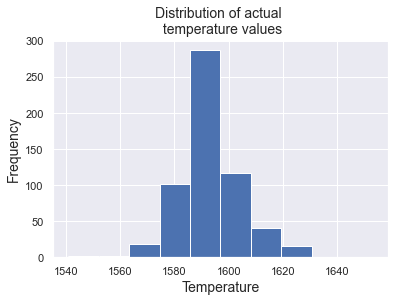

In [104]:
y_test.hist().set_title('Distribution of actual \n temperature values', 
                                         fontsize=14)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

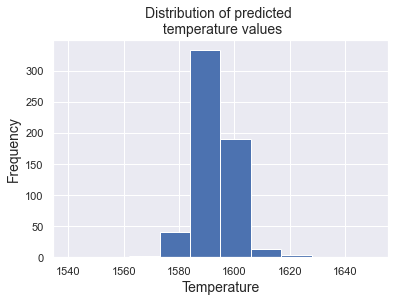

In [105]:
pd.Series(np.array(pipe.predict(X_test), y_test)).hist(range=(1540, 1650)
    ).set_title('Distribution of predicted \n temperature values', fontsize=14)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

It can be seen from the graphs that the predicted temperature values coincide quite well with the real values.

# Feature significance visualization

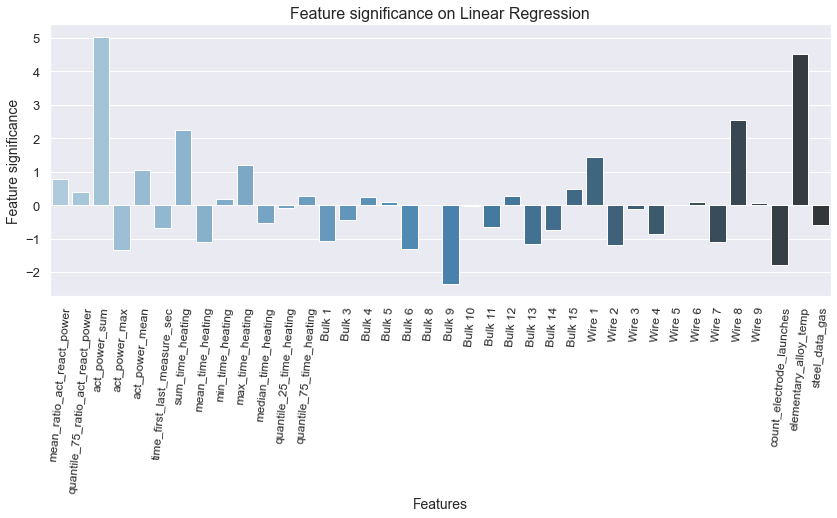

In [106]:
importance = lr.coef_
feature_importance_list = []
for i, v in enumerate(importance):
    feature_importance_list.append([features.columns.tolist()[i], v])
    
feature_importance_df = pd.DataFrame(feature_importance_list)
feature_importance_df.columns = ['feature', 'importamse_coeff']

ax = plt.subplots(figsize=(14, 5))
sns.barplot(x='feature', y='importamse_coeff', data=feature_importance_df, palette="Blues_d"
           ).set_title('Feature significance on Linear Regression', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature significance', fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(fontsize=12, rotation=85);

There are 3 most important features:
- active power value
- primary alloy temperature
- 8 batch (wire 8) wire materials

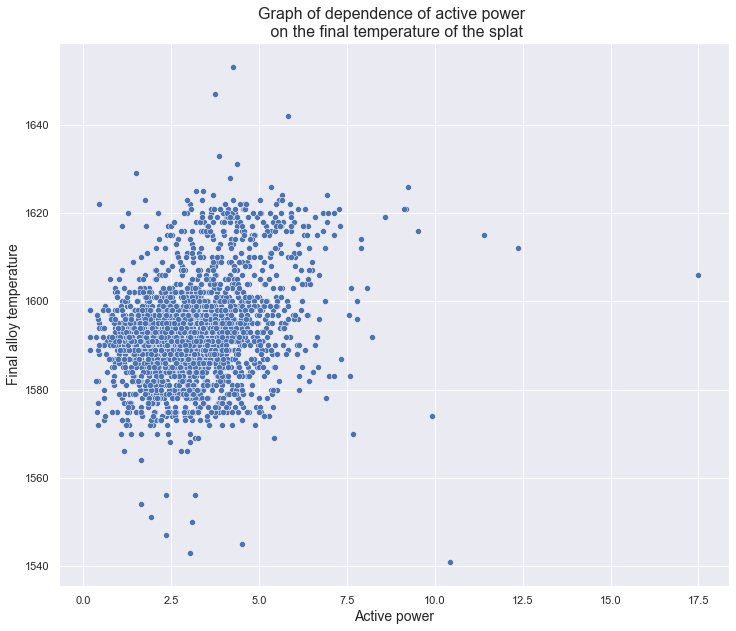

In [107]:
ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x='act_power_sum', y='target', data=input_df, palette="Blues_d"
           ).set_title('Graph of dependence of active power \n on the final temperature of the splat', fontsize=16)
plt.xlabel('Active power', fontsize=14)
plt.ylabel('Final alloy temperature', fontsize=14);

The graph shows that, on average, at a final temperature of 1590, the active power is 2.5

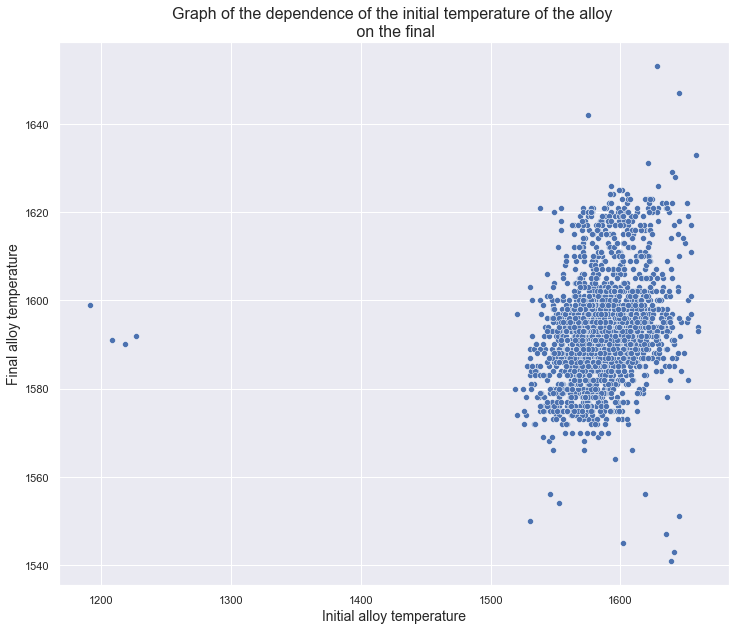

In [108]:
ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(x='elementary_alloy_temp', y='target', data=input_df, palette="Blues_d"
           ).set_title('Graph of the dependence of the initial temperature of the alloy \n on the final', fontsize=16)
plt.xlabel('Initial alloy temperature', fontsize=14)
plt.ylabel('Final alloy temperature', fontsize=14);

The graph shows that the average temperature of the alloy differs from the final one by several tens of degrees (somewhere more, somewhere less).

# Final conclusion

During this project, work was done to develop a model for predicting the temperature of the alloy.

At the beginning of the project, an exploratory data analysis was performed, as well as their preprocessing. Missing values in features were filled with zeros, anomalies were removed. In the target characteristic, rows with missing values have been removed. Data scaling was also performed. To avoid data leakage during cross-validation, scaling was performed inside the pipeline at the model training stage.

To improve the quality of the model, additional features were generated. However, not all additional features had a positive impact on the metric. The signs themselves and their number were determined empirically, as well as using correlation analysis.

As part of the training, 4 models were considered: linear regression, decision tree, gradient boosting model (CatBoost library) and a fully connected neural network. In each model, the selection of hyperparameters was carried out on cross-validation. On all models, except for linear regression, the selection of hyperparameters was made using GridSearch.

The best model proved to be a linear regression model with a metric of 6.51 on test data. The model was compared with a random model. The model is 21% more efficient than the random one.